# Proyecto análisis y gestión de recursos aeroportuarios del Aeroparque Jorge Newbery

### Big Data Bang: explosionando las rutas aéreas para predecir un caos en alto vuelo.
---


Grupo número 2:
* Francisco Brogiolo
* Miguel Cittadini
* Marcelo Bianchi
* Martín Brogiolo

# TP 3  Aprendizaje Supervisado

En este trabajo analizamos distintos modelos para predecir los retrasos. Dado que no obtuvimos buenos resultados desde el momento inicial, decidimos automatizar el pre procesado para poder probar distintas configuraciones. A continuación presentamos las funciones:

## Preprocesado

### Funciones y librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

Función que completa el pre-procesado de la base de datos:

In [ ]:
def preprocessing(df,base_binaria,top_variables,type_encoding,sacar_pas_0,sacar_buenos_aires,minutos_retraso):

  df = definir_filtros(minutos_retraso,top_variables,base_binaria, sacar_buenos_aires, sacar_pas_0,df)
  print("Df sin encoding: ")
  display(df)

  df = encoding(df,type_encoding )
  print("Df after encoding: ")
  display(df)

  df = normalizar(df)
  print("Df normalizada: ")
  display(df)

  return df

Aplica los filtros en el df:

In [ ]:
def definir_filtros(minutos_retraso,top_variables,base_binaria, sacar_buenos_aires, sacar_pas_0,df):

  if minutos_retraso != 30:
    print("Consideramos ", minutos_retraso, "minutos como retraso.")
    df['Retraso'] = df['Retraso_Minutos'].apply(lambda x: 1 if x > minutos_retraso else (-1 if x < -minutos_retraso else 0))

    print("Distribución de retrasos/adelantos")
    print(df.Retraso.value_counts())

  if top_variables:
    columnas_filtro = ['Riesgo_Vuelos_Ult_8_hs', 'Cant_Pasajeros', 'Hora_Vuelo',
          'Distancia_km',  'Mes_Vuelo',
          'Pais_Aeropuerto', 'Ciudad_Aeropuerto', 'Nombre_Aerolinea', 'Dia_Semana','Retraso']

    #probamos lo que sugiere Noe de poner menos variables aún
    columnas_filtro = ['Riesgo_Vuelos_Ult_8_hs', 'Hora_Vuelo',
          'Pais_Aeropuerto', 'Ciudad_Aeropuerto', 'Nombre_Aerolinea','Retraso']

    print("Elegimos usar solo las principales ", len(columnas_filtro)-1, " columnas como features.")

  else:
    columnas_filtro = ['Riesgo_Vuelos_Ult_8_hs', 'Cant_Pasajeros', 'Hora_Vuelo',
        'Cinta_Equipajes', 'Distancia_km', 'Cabecera_Arribo', 'Mes_Vuelo',
        'Pais_Aeropuerto', 'Ciudad_Aeropuerto', 'Nombre_Aerolinea', 'Sector', 'Dia_Semana',
        'Uso_Aeronave', 'Terminal_Arribo','Retraso']
    print("Usamos todas las ", len(columnas_filtro)-1, " features originales")

  df = df[columnas_filtro]

  if base_binaria:
      df.loc[df['Retraso'] == -1, 'Retraso'] = 0

      print("Elegimos resolver un problema de clasificación binaria.")
  else: print("Elegimos resolver un problema de multiclase, incluyendo adelantos.")


  if sacar_buenos_aires:
    print("Se excluyen los vuelos con origen en buenos aires.")
    df = df[df['Ciudad_Aeropuerto'] != 'Buenos Aires']

  if sacar_pas_0:
    print("Se excluyen los vuelos sin pasajeros del análisis.")
    if 'Cant_Pasajeros' in df.columns:
      df = df[df['Cant_Pasajeros'] != 0]

  return df

Funciones útiles para el encoding:

In [ ]:
#Debemos convertir a variables categóricas todas las que no sean numéricas:
def convert_to_categorical(df):
  son_categoricas= ["Hora_Vuelo", "Cinta_Equipajes", "Cabecera_Arribo", "Mes_Vuelo","Dia_Semana"]

  for columna in son_categoricas:
    try:
      df[columna] = df[columna].astype('category')
    except: continue
  return df


#Debemos convertir a variables float todas las que antes eran categóricas:
def convert_to_float(df):
  son_categoricas= ["Hora_Vuelo", "Cinta_Equipajes", "Cabecera_Arribo", "Mes_Vuelo","Dia_Semana"]

  for columna in son_categoricas:
    try:
      df[columna] = df[columna].astype(float)
    except: continue
  return df


def classify_categorical_variables(df):
  df = convert_to_categorical(df)

  # Obtener las columnas categóricas
  categorical_columns = df.select_dtypes(include=['object', 'category']).columns

  # Crear dos listas para almacenar los resultados
  more_than_5_vars = []
  less_than_5_vars = []

  # Iterar sobre las columnas categóricas
  for column in categorical_columns:
      unique_values = df[column].nunique()  # Contar valores únicos en la columna

      # Separar las columnas en las listas correspondientes
      if unique_values >= 5:
          more_than_5_vars.append(column)
      else:
          less_than_5_vars.append(column)

  return less_than_5_vars,more_than_5_vars


def encoding(df, type_encoding = "label"):

  less_than_5_vars,more_than_5_vars = classify_categorical_variables(df)
  df_encoded = pd.get_dummies(df, columns=less_than_5_vars)

  print("Realizamos ",type_encoding, "encoding para columnas con más de 5 categorías. Para menos de 5 mantenemos one-hot")

  if type_encoding == "one-hot":
    df_encoded = pd.get_dummies(df_encoded, columns=more_than_5_vars)

  elif type_encoding == "label":

    etiquetas = {} # Definir etiquetas para el label encoding

    for variable in more_than_5_vars:  # Aplicar label encoding en las variables seleccionadas
        etiquetas[variable] = {}
        etiqueta_actual = 0
        for valor in df_encoded[variable].unique():
            etiquetas[variable][valor] = etiqueta_actual
            etiqueta_actual += 1
        df_encoded[variable] = df_encoded[variable].replace(etiquetas[variable])

  elif type_encoding == "target":
    # Create a dictionary to store target encodings
      target_encodings = {}

      # Calculate target encodings for the selected variables
      for variable in more_than_5_vars:
          encoding_map = df.groupby(variable)['Retraso'].mean().to_dict()
          target_encodings[variable] = encoding_map
          df_encoded[variable] = df_encoded[variable].map(encoding_map) #directamente reemplazo la variable original por la variable con encoding

  else: print("Type of encoding not allowed")

  df_encoded = convert_to_float(df_encoded)

  return df_encoded

Normalizado:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalizar(df):
  scaler = MinMaxScaler()

  scaler = MinMaxScaler()

  # Itera a través de todas las columnas del DataFrame
  for columna in df.columns:
    if columna != "Retraso":
      # Verifica si la columna contiene valores numéricos (ignora columnas no numéricas)
      if df[columna].dtype in ['int64', 'float64']:
          # Calcula el valor mínimo y máximo de la columna
          min_valor = df[columna].min()
          max_valor = df[columna].max()

          # Verifica si la columna tiene valores fuera del rango [0, 1]
          if min_valor < 0 or max_valor > 1:
              # Normaliza la columna y la reemplaza en el DataFrame original
              df[columna] = scaler.fit_transform(df[[columna]])

  return df

### Definición de variables de preprocesado y aplicar las funciones:

A continuación una explicación de qué hace cada variable en la etapa de pre-procesado:

base_binaria = True: no predecimos adelantos. False: sí predecimos adelantos.

top_variables = True: solo usamos las variables más significativas. False: usamos todas.

type_encoding = "target"/"label"
sacar_pas_0 = False #false es para que NO estén los vuelos con 0 pasajeros, ya que no son comerciales.

sacar_buenos_aires = False #false es para que NO estén los vuelos con 0 origen en buenos aires, ya que presentan mucho más retraso que los otros.

minutos_retraso = 15: define el threshold a partir del cual un vuelo se considera retrasado.

test_size = 0.2. Tamaño del set de test en % del total de muestras.

In [ ]:
base_binaria = True
top_variables = True
type_encoding = "target" #Possible values are "one-hot", "target" or "label"
sacar_pas_0 = False #false es para que NO estén los vuelos con 0 pasajeros
sacar_buenos_aires = False
minutos_retraso = 15

test_size = 0.2
aplicar_dummie = True

df = pd.read_csv("https://raw.githubusercontent.com/Fran-Brogiolo/DataScienceDiploma/master/Mentor%C3%ADa%20Big%20Data%20Bang/df_final_sin_encoding_TP2.csv", parse_dates=['Horario_Prog_Arribo'])
df = preprocessing(df,base_binaria,top_variables,type_encoding,sacar_pas_0,sacar_buenos_aires,minutos_retraso)
df.info()

Consideramos  15 minutos como retraso.
Distribución de retrasos/adelantos
 0    75518
-1    35741
 1    14324
Name: Retraso, dtype: int64
Elegimos usar solo las principales  5  columnas como features.
Elegimos resolver un problema de clasificación binaria.
Df sin encoding: 


,Riesgo_Vuelos_Ult_8_hs,Hora_Vuelo,Pais_Aeropuerto,Ciudad_Aeropuerto,Nombre_Aerolinea,Retraso
0,0,1,Argentina,Puerto Iguazú,DN,0
1,0,8,Argentina,Córdoba,DN,0
2,0,9,Argentina,Córdoba,4M,0
3,0,9,Brasil,São Paulo,4M,0
4,0,8,Argentina,Mendoza,AR,0
...,...,...,...,...,...,...
125578,0,19,Argentina,Neuquén,PRV,0
125579,0,6,Argentina,Mendoza,PRV,0
125580,0,7,Argentina,Mendoza,PRV,0
125581,0,8,Argentina,San Juan,PRV,0


Realizamos  target encoding para columnas con más de 5 categorías. Para menos de 5 mantenemos one-hot
Df after encoding: 


<ipython-input-96-f0c4ceddeca2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columna] = df[columna].astype('category')


,Riesgo_Vuelos_Ult_8_hs,Hora_Vuelo,Pais_Aeropuerto,Ciudad_Aeropuerto,Nombre_Aerolinea,Retraso
0,0,0.170543,0.115554,0.130755,0.091239,0
1,0,0.049518,0.115554,0.109135,0.091239,0
2,0,0.081764,0.115554,0.109135,0.127052,0
3,0,0.081764,0.113738,0.120848,0.127052,0
4,0,0.049518,0.115554,0.100864,0.106582,0
...,...,...,...,...,...,...
125578,0,0.114245,0.115554,0.114290,0.046698,0
125579,0,0.100392,0.115554,0.100864,0.046698,0
125580,0,0.067518,0.115554,0.100864,0.046698,0
125581,0,0.049518,0.115554,0.138796,0.046698,0


Df normalizada: 


,Riesgo_Vuelos_Ult_8_hs,Hora_Vuelo,Pais_Aeropuerto,Ciudad_Aeropuerto,Nombre_Aerolinea,Retraso
0,0,0.170543,0.115554,0.130755,0.091239,0
1,0,0.049518,0.115554,0.109135,0.091239,0
2,0,0.081764,0.115554,0.109135,0.127052,0
3,0,0.081764,0.113738,0.120848,0.127052,0
4,0,0.049518,0.115554,0.100864,0.106582,0
...,...,...,...,...,...,...
125578,0,0.114245,0.115554,0.114290,0.046698,0
125579,0,0.100392,0.115554,0.100864,0.046698,0
125580,0,0.067518,0.115554,0.100864,0.046698,0
125581,0,0.049518,0.115554,0.138796,0.046698,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125583 entries, 0 to 125582
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Riesgo_Vuelos_Ult_8_hs  125583 non-null  int64  
 1   Hora_Vuelo              125583 non-null  float64
 2   Pais_Aeropuerto         125583 non-null  float64
 3   Ciudad_Aeropuerto       125583 non-null  float64
 4   Nombre_Aerolinea        125583 non-null  float64
 5   Retraso                 125583 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 5.7 MB


Parece que cambiara la hora pero en realidad al ser variable categórica, es lo mismo que código se le asigne.

## 1) Preparación de los datos para aplicar modelos de clasificación:


### Funciones

Asimismo, aplicamos funciones para generar los datasets de prueba y test de manera automática, y dado que el dataset está desbalanceado, probamos 3 formas de balanceo: oversampling, SMOTE y SMOTEEN

In [ ]:
#Separo el df en atributos y target:
def separar_x_y(df):
  X = df.drop('Retraso', axis=1)
  y = df["Retraso"].copy()
  #y["Retraso"] = y["Retraso"].astype('uint8')
  return X, y

#Separo en entrenamiento y test
from sklearn.model_selection import train_test_split
def train_test_normal(X, y, test_size=0.3):

  # Mostrar la proporción de clases antes de la separación
  class_distribution_before = y.value_counts(normalize=True)
  print("Proporción de clases antes de la separación:")
  print(class_distribution_before)

  # Dividir en conjuntos de entrenamiento y temporal
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, stratify=y, random_state=42)

  # Mostrar la proporción de clases después de la separación en cada conjunto
  print("\nProporción de clases en el conjunto de entrenamiento:")
  print(y_train.value_counts(normalize=True))
  print("\nProporción de clases en el conjunto de prueba:")
  print(y_test.value_counts(normalize=True))
  print("Tenemos",len(y_train),"entradas de entrenamiento")
  print("Tenemos",len(y_test),"entradas de test")
  return X_train, X_test, y_train, y_test


#Genero el training con oversampling
from collections import Counter
def train_test_oversampling(X_train, y_train):
  from imblearn.over_sampling import RandomOverSampler
  os =  RandomOverSampler(random_state=42)
  X_train_res, y_train_res = os.fit_resample(X_train, y_train)

  print ("Distribucion antes del resampling {}".format(Counter(y_train)))
  print ("Distribucion despues del resampling {}".format(Counter(y_train_res)))

  return X_train_res, y_train_res


Probamos 2 distintas formas de SMOTE para balanceo de clases:

In [ ]:
pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

def train_test_over_SMOTE(X_train, y_train):
  smote = SMOTE(random_state=42)
  X_train_Smote, y_train_Smote = smote.fit_resample(X_train, y_train)

  print ("Distribucion antes del resampling {}".format(Counter(y_train)))
  print ("Distribucion despues del resampling {}".format(Counter(y_train_Smote)))

  return X_train_Smote, y_train_Smote

from imblearn.combine import SMOTEENN
def train_test_over_SMOTE_2(X_train, y_train):
  smote_enn = SMOTEENN(random_state=42,sampling_strategy='auto')
  X_train_Smote2, y_train_Smote2 = smote_enn.fit_resample(X_train, y_train)

  print ("Distribucion antes del resampling {}".format(Counter(y_train)))
  print ("Distribucion despues del resampling {}".format(Counter(y_train_Smote)))

  return X_train_Smote2, y_train_Smote2

### a) Generar a partir del dataset, los conjuntos de train, test y validation.

In [ ]:
X, y = separar_x_y(df)
X_train, X_test, y_train, y_test = train_test_normal(X, y, test_size)

Proporción de clases antes de la separación:
0    0.88594
1    0.11406
Name: Retraso, dtype: float64

Proporción de clases en el conjunto de entrenamiento:
0    0.885942
1    0.114058
Name: Retraso, dtype: float64

Proporción de clases en el conjunto de prueba:
0    0.885934
1    0.114066
Name: Retraso, dtype: float64
Tenemos 100466 entradas de entrenamiento
Tenemos 25117 entradas de test


### b) Analizar las proporciones consideradas para cada conjunto con respecto al total del dataset. Verificar el total de datos de cada conjunto.

Las proporciones varían según el tiempo elegido de retraso y si incluimos o no vuelos sin pasajeros o con origen en Bs As. Para un retraso de 15', e incluyendo vuelos sin pasajeros y desde Bs As el % de retrasos es 11.4%

### c) Para cada conjunto (train, test, val), ¿cuántos datos de cada clase target hay?, se debe buscar mantener la proporción del dataset total.

Ahora generaremos un set de datos que este balanceado con 3 formas distintas: oversampling y 2 SMOTE distintos:

In [ ]:
#Oversampling
print("Oversampling")
X_train_res, y_train_res = train_test_oversampling(X_train, y_train)
#Smote
print("Smote")
X_train_Smote, y_train_Smote = train_test_over_SMOTE(X_train, y_train)
#Smote 2
print("Smote 2")
X_train_Smote2, y_train_Smote2 = train_test_over_SMOTE_2(X_train, y_train)

Oversampling
Distribucion antes del resampling Counter({0: 89007, 1: 11459})
Distribucion despues del resampling Counter({0: 89007, 1: 89007})
Smote
Distribucion antes del resampling Counter({0: 89007, 1: 11459})
Distribucion despues del resampling Counter({0: 89007, 1: 89007})
Smote 2
Distribucion antes del resampling Counter({0: 89007, 1: 11459})
Distribucion despues del resampling Counter({0: 89007, 1: 89007})


## 2) Creación de un modelo baseline:


### Creación de un df para ir guardando los f1 score y luego poder comparar.

In [ ]:
def create_df_metricas():
  columnas_metricas = ['base_binaria', 'top_variables', 'type_encoding', 'sacar_pas_0',
              'sacar_buenos_aires', 'minutos_retraso', 'balanceo',
              'modelo','f1_score_retrasos','recal_retrasos','precision_retrasos','total_accuracy'
              ]

  df_metricas = pd.DataFrame(columns=columnas_metricas)

  return df_metricas

In [ ]:
def sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        balanceo, modelo, f1_score_retrasos,recal_retrasos,precision_retrasos,total_accuracy):
    global df_metricas
    configuracion = {
    'base_binaria': base_binaria,
    'top_variables': top_variables,
    'type_encoding': type_encoding,
    'sacar_pas_0': sacar_pas_0,
    'sacar_buenos_aires': sacar_buenos_aires,
    'minutos_retraso': minutos_retraso,
    'balanceo': balanceo,
    'modelo': modelo,
    'f1_score_retrasos': f1_score_retrasos,
    'recal_retrasos':recal_retrasos,
    'precision_retrasos':precision_retrasos,
    'total_accuracy':total_accuracy
      }

    df_metricas = df_metricas.append(configuracion, ignore_index=True)


### Funciones

In [ ]:
# Muestra la matriz de confusión
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
def matriz_confusion(y_real, y_pred, evaluar = "training"):
  print("Resultado en", evaluar, ":")
  ConfusionMatrixDisplay.from_predictions(y_real, y_pred)
  plt.show()
  print(classification_report(y_real, y_pred))

In [ ]:
from sklearn.dummy import DummyClassifier
import seaborn as sns
def dummy_model(X_train,y_train,X_test,y_test):
  dummy_clf = DummyClassifier(strategy="most_frequent", random_state = 42)
  dummy_clf.fit(X_train, y_train)
  y_train_pred = dummy_clf.predict(X_train)
  y_test_pred = dummy_clf.predict(X_test)

  #matriz_confusion(y_train,y_train_pred)

  matriz_confusion(y_test,y_test_pred, "test")

  return y_train_pred,y_test_pred

In [ ]:
from sklearn import metrics

def plot_roc(test_labels, target_predicted):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print("Sensitivity or TPR: ", Sensitivity, "%")
    print( "Specificity or TNR: ",Specificity, "%")
    print("Precision: ",Precision, "%")
    print("Negative Predictive Value: ",NPV, "%")
    print( "False Positive Rate: ",FPR,"%")
    print("False Negative Rate: ",FNR, "%")
    print("False Discovery Rate: ",FDR, "%" )
    print("Accuracy: ",ACC, "%")

    test_labels = test.iloc[:,0];
    print("Validation AUC", metrics.roc_auc_score(test_labels, target_predicted) )

    fpr, tpr, thresholds = metrics.roc_curve(test_labels, target_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

In [ ]:
def apply_dummie(X_train, X_test, y_train, y_test,X_train_res, y_train_res,X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2):
  print("----------Aplicando modelo dummie----------")
  print("-----Database original-----")
  dummy_model(X_train,y_train,X_test,y_test)
  print("-----Database oversampled-----")
  dummy_model(X_train_res,y_train_res,X_test,y_test)
  print("-----Database Smote-----")
  dummy_model(X_train_Smote,y_train_Smote,X_test,y_test)
  print("-----Database Smote2-----")
  dummy_model(X_train_Smote2,y_train_Smote2,X_test,y_test)

### a) Entrenar un modelo “baseline”, es decir lo más simple posible, para con ello tener un punto de partida con el cual comparar modelos más complejos. Fijar la semilla aleatoria para hacer repetible el experimento (Hint: se puede usar por ejemplo la clase “DummyClassifier” de scikit-learn)

Documentación:
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

----------Aplicando modelo dummie----------
-----Database original-----
Resultado en test :


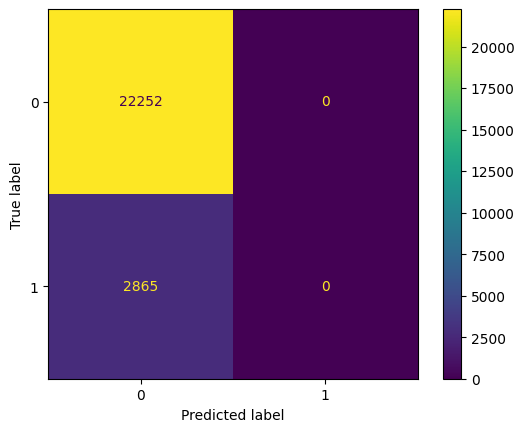

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     22252
           1       0.00      0.00      0.00      2865

    accuracy                           0.89     25117
   macro avg       0.44      0.50      0.47     25117
weighted avg       0.78      0.89      0.83     25117

-----Database oversampled-----
Resultado en test :


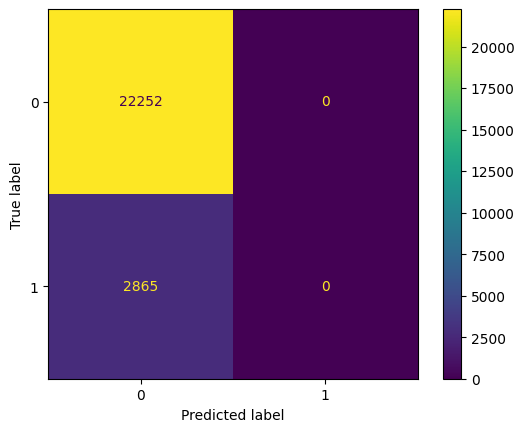

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     22252
           1       0.00      0.00      0.00      2865

    accuracy                           0.89     25117
   macro avg       0.44      0.50      0.47     25117
weighted avg       0.78      0.89      0.83     25117

-----Database Smote-----
Resultado en test :


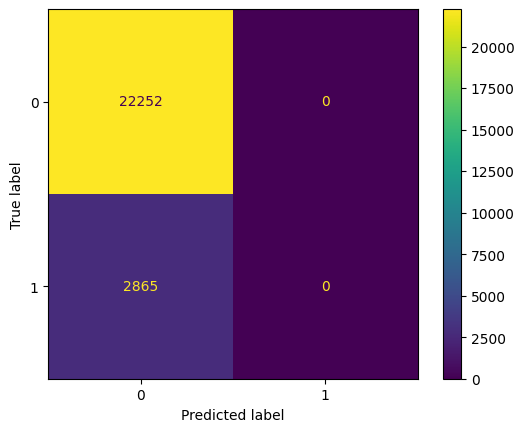

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     22252
           1       0.00      0.00      0.00      2865

    accuracy                           0.89     25117
   macro avg       0.44      0.50      0.47     25117
weighted avg       0.78      0.89      0.83     25117

-----Database Smote2-----
Resultado en test :


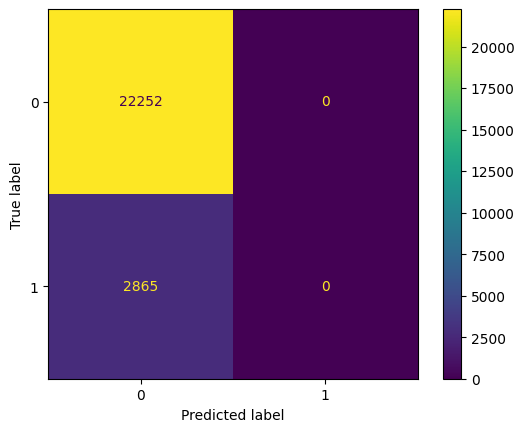

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     22252
           1       0.00      0.00      0.00      2865

    accuracy                           0.89     25117
   macro avg       0.44      0.50      0.47     25117
weighted avg       0.78      0.89      0.83     25117



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
if aplicar_dummie:
  apply_dummie(X_train, X_test, y_train, y_test,X_train_res, y_train_res,X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2)

### b)  Evaluar sobre el conjunto de entrenamiento, validación y test reportando: i. Accuracy ii. Precision iii. Recall iv. F1 v. Matriz de confusión


Como vemos arriba, el modelo dummie no predice nada.

### c) Pensar cuál métrica es conveniente optimizar en éste problema de clasificación donde se predice el retraso de los vuelos. ¿Sería el Accuracy una buena métrica?

Evaluaremos como métrica principal el f1 score para la clase de retrasos, ya que considera precisión y recall.

## 3)  Predicción de modelos lineales:


### Funciones

In [ ]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
import seaborn as sns

In [ ]:
def regresionlog_y_SGD(X_train,y_train,X_test,y_test):
  # Entrenar un modelo de regresión logística
  logreg_model = LogisticRegression(random_state=42)
  logreg_model.fit(X_train, y_train)

  # Predecir en el conjunto de prueba y calcular la exactitud
  y_pred_logreg = logreg_model.predict(X_test)
  #accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

  #matriz_confusion(y_train,dummy_clf.predict(X_train))
  print("Regresion logistica: ")
  matriz_confusion(y_test,y_pred_logreg, "test")

  f1_retraso_logreg = round(f1_score(y_test, y_pred_logreg, labels=[1], average='macro'),3)
  print("F1 retrasos regr. logística ", f1_retraso_logreg)

  # Recall (Sensibilidad)
  recall_reg = round(recall_score(y_test, y_pred_logreg, labels=[1], average='macro'),3)

  # Precision
  precision_reg = round(precision_score(y_test, y_pred_logreg, labels=[1], average='macro'),3)

  # Total Accuracy
  accuracy_reg = round(accuracy_score(y_test, y_pred_logreg),3)


  # Entrenar el modelo SGDClassifier
  sgd_model = SGDClassifier(random_state=42)
  sgd_model.fit(X_train, y_train)

  # Predecir en el conjunto de prueba y calcular la exactitud
  y_pred_sgd = sgd_model.predict(X_test)

  print("SGD Classifier: ")
  matriz_confusion(y_test,y_pred_sgd, "test")

  f1_retraso_SGD = round(f1_score(y_test, y_pred_sgd, labels=[1], average='macro'),3)
  print("F1 retrasos SGD ", f1_retraso_SGD)

  # Recall (Sensibilidad)
  recall_sgd = round(recall_score(y_test, y_pred_sgd, labels=[1], average='macro'),3)

  # Precision
  precision_sgd = round(precision_score(y_test, y_pred_sgd, labels=[1], average='macro'),3)

  # Total Accuracy
  accuracy_sgd = round(accuracy_score(y_test, y_pred_sgd),3)

  return f1_retraso_logreg,recall_reg,precision_reg,accuracy_reg, f1_retraso_SGD, recall_sgd,precision_sgd,accuracy_sgd

In [ ]:
def apply_regresionlog_y_SGD(X_train, X_test, y_train, y_test,X_train_res, y_train_res,
                             X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2, apply_all=True):
  print("----------Aplicando modelo de regresión logística y SGD classifier----------")

  if apply_all:
    print("-----Database original-----")
    f1_retraso_logreg, recall_reg, precision_reg, accuracy_reg, \
    f1_retraso_SGD, recall_sgd, precision_sgd, accuracy_sgd = regresionlog_y_SGD(X_train, y_train, X_test, y_test)

    sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Sin balanceo", "Regresión logística", f1_retraso_logreg,recall_reg, precision_reg, accuracy_reg)

    sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Sin balanceo", "SGD", f1_retraso_SGD, recall_sgd, precision_sgd, accuracy_sgd)

  print("-----Database oversampled-----")
  f1_retraso_logreg, recall_reg, precision_reg, accuracy_reg, \
  f1_retraso_SGD, recall_sgd, precision_sgd, accuracy_sgd = regresionlog_y_SGD(X_train_res,y_train_res,X_test,y_test)

  sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Oversampling", "Regresión logística", f1_retraso_logreg,recall_reg, precision_reg, accuracy_reg)

  sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Oversampling", "SGD", f1_retraso_SGD, recall_sgd, precision_sgd, accuracy_sgd)


  print("-----Database Smote-----")
  f1_retraso_logreg, recall_reg, precision_reg, accuracy_reg, \
  f1_retraso_SGD, recall_sgd, precision_sgd, accuracy_sgd = regresionlog_y_SGD(X_train_Smote,y_train_Smote,X_test,y_test)


  sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Smote", "Regresión logística", f1_retraso_logreg,recall_reg, precision_reg, accuracy_reg)

  sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Smote", "SGD", f1_retraso_SGD, recall_sgd, precision_sgd, accuracy_sgd)
  if apply_all:
    print("-----Database Smote2-----")
    f1_retraso_logreg, recall_reg, precision_reg, accuracy_reg, \
    f1_retraso_SGD, recall_sgd, precision_sgd, accuracy_sgd = regresionlog_y_SGD(X_train_Smote2,y_train_Smote2,X_test,y_test)

    sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Smote2", "Regresión logística", f1_retraso_logreg,recall_reg, precision_reg, accuracy_reg)

    sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Smote2", "SGD", f1_retraso_SGD, recall_sgd, precision_sgd, accuracy_sgd)

### a)  Entrenar modelos lineales de clasificación para predecir la variable objetivo. Para ello, deberán utilizar “LogisticRegression” de scikit-learn. Fijar la semilla aleatoria para hacer repetible el experimento y elegir al menos uno de los siguientes otros modelos:
### i. La clase SGDClassifier de scikit-learn.
### ii. La clase LinearSVC de scikit-learn.

Documentación:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/sgd.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

In [ ]:
df_metricas = create_df_metricas()

----------Aplicando modelo de regresión logística y SGD classifier----------
-----Database original-----
Regresion logistica: 
Resultado en test :


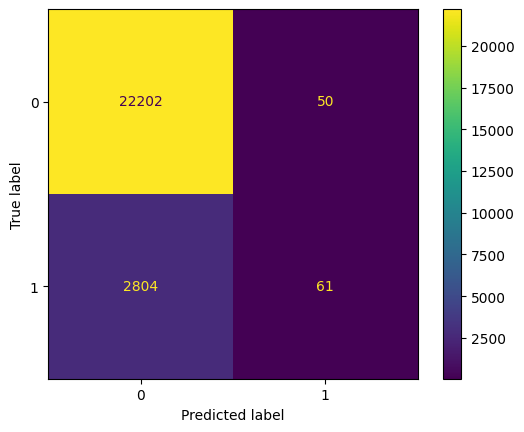

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     22252
           1       0.55      0.02      0.04      2865

    accuracy                           0.89     25117
   macro avg       0.72      0.51      0.49     25117
weighted avg       0.85      0.89      0.84     25117

F1 retrasos regr. logística  0.041
SGD Classifier: 
Resultado en test :


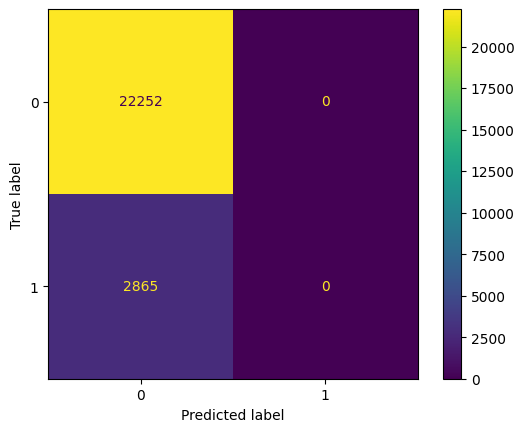

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     22252
           1       0.00      0.00      0.00      2865

    accuracy                           0.89     25117
   macro avg       0.44      0.50      0.47     25117
weighted avg       0.78      0.89      0.83     25117

F1 retrasos SGD  0.0
-----Database oversampled-----
Regresion logistica: 
Resultado en test :


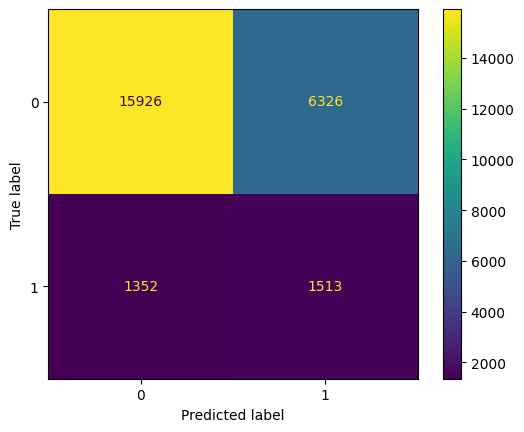

              precision    recall  f1-score   support

           0       0.92      0.72      0.81     22252
           1       0.19      0.53      0.28      2865

    accuracy                           0.69     25117
   macro avg       0.56      0.62      0.54     25117
weighted avg       0.84      0.69      0.75     25117

F1 retrasos regr. logística  0.283
SGD Classifier: 
Resultado en test :


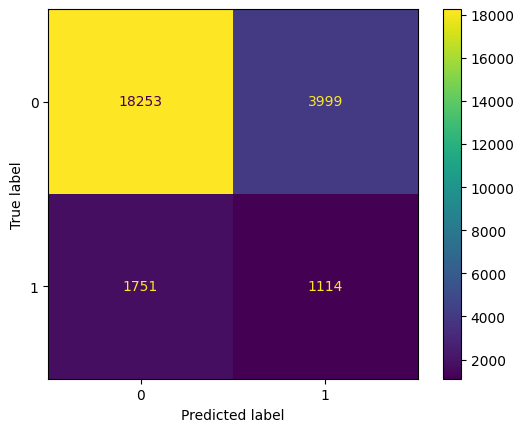

              precision    recall  f1-score   support

           0       0.91      0.82      0.86     22252
           1       0.22      0.39      0.28      2865

    accuracy                           0.77     25117
   macro avg       0.57      0.60      0.57     25117
weighted avg       0.83      0.77      0.80     25117

F1 retrasos SGD  0.279
-----Database Smote-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.appen

Regresion logistica: 
Resultado en test :


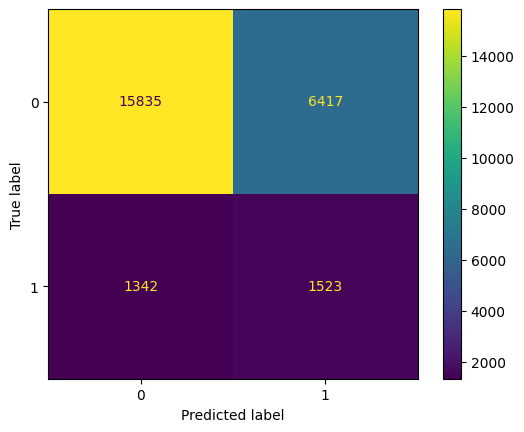

              precision    recall  f1-score   support

           0       0.92      0.71      0.80     22252
           1       0.19      0.53      0.28      2865

    accuracy                           0.69     25117
   macro avg       0.56      0.62      0.54     25117
weighted avg       0.84      0.69      0.74     25117

F1 retrasos regr. logística  0.282
SGD Classifier: 
Resultado en test :


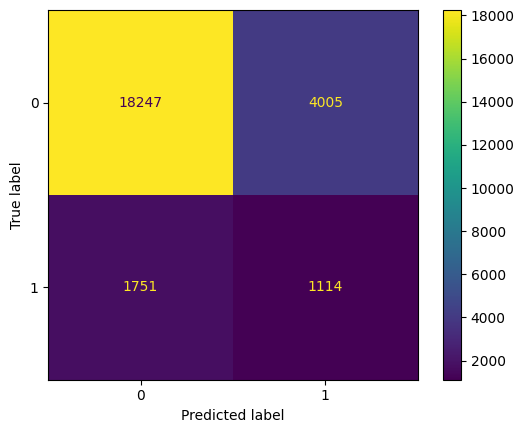

              precision    recall  f1-score   support

           0       0.91      0.82      0.86     22252
           1       0.22      0.39      0.28      2865

    accuracy                           0.77     25117
   macro avg       0.57      0.60      0.57     25117
weighted avg       0.83      0.77      0.80     25117

F1 retrasos SGD  0.279
-----Database Smote2-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.appen

Regresion logistica: 
Resultado en test :


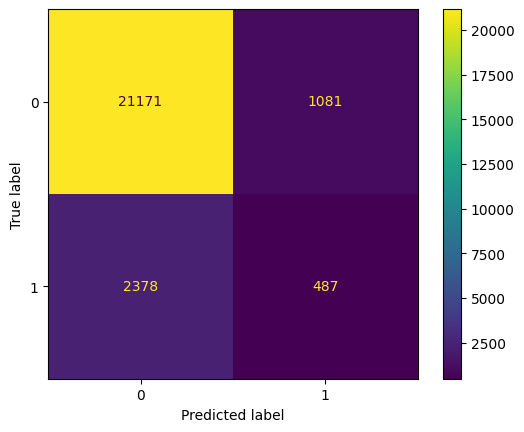

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     22252
           1       0.31      0.17      0.22      2865

    accuracy                           0.86     25117
   macro avg       0.60      0.56      0.57     25117
weighted avg       0.83      0.86      0.84     25117

F1 retrasos regr. logística  0.22
SGD Classifier: 
Resultado en test :


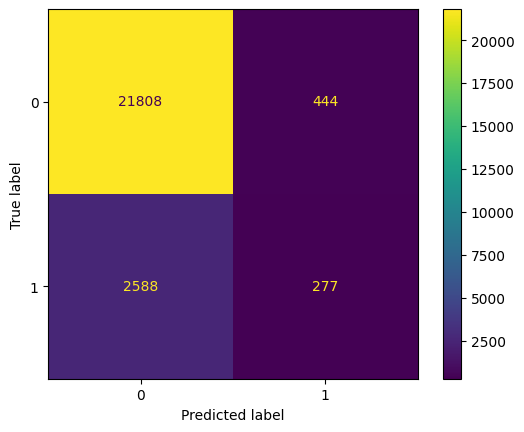

              precision    recall  f1-score   support

           0       0.89      0.98      0.94     22252
           1       0.38      0.10      0.15      2865

    accuracy                           0.88     25117
   macro avg       0.64      0.54      0.54     25117
weighted avg       0.84      0.88      0.85     25117

F1 retrasos SGD  0.154


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.appen

In [ ]:
apply_regresionlog_y_SGD(X_train, X_test, y_train, y_test,X_train_res, y_train_res,X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2)

In [ ]:
df_metricas

,base_binaria,top_variables,type_encoding,sacar_pas_0,sacar_buenos_aires,minutos_retraso,balanceo,modelo,f1_score_retrasos,recal_retrasos,precision_retrasos,total_accuracy
0,True,True,target,False,False,15,Sin balanceo,Regresión logística,0.041,0.021,0.550,0.886
1,True,True,target,False,False,15,Sin balanceo,SGD,0.000,0.000,0.000,0.886
2,True,True,target,False,False,15,Oversampling,Regresión logística,0.283,0.528,0.193,0.694
3,True,True,target,False,False,15,Oversampling,SGD,0.279,0.389,0.218,0.771
4,True,True,target,False,False,15,Smote,Regresión logística,0.282,0.532,0.192,0.691
5,True,True,target,False,False,15,Smote,SGD,0.279,0.389,0.218,0.771
6,True,True,target,False,False,15,Smote2,Regresión logística,0.220,0.170,0.311,0.862
7,True,True,target,False,False,15,Smote2,SGD,0.154,0.097,0.384,0.879


### b)  Evaluar sobre el conjunto de entrenamiento, validación y test reportando: i. Accuracy ii. Precision iii. Recall iv. F1 v. Matriz de confusión


### c) Elaborar conclusiones en base a la métrica a optimizar y comparar con el modelo baseline.

Vemos que funciona mejor la regresión logística y que las mejores formas de sampleo son oversampling y smote. Logramos un f1 de 28% para la clase 1, sigue siendo muy bajo.

## 4)  Predicción de modelos basados en árboles de decisión:


### Funciones

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import ensemble
from xgboost import XGBClassifier

In [ ]:
def decision_tree(X_train,y_train,X_test,y_test):

  tree_model = DecisionTreeClassifier(random_state=42)
  tree_model.fit(X_train, y_train)
  y_pred = tree_model.predict(X_test)

  print("Decision Tree: ")
  matriz_confusion(y_test,y_pred, "test")

  f1= round(f1_score(y_test, y_pred, labels=[1], average='macro'),3)
  print("F1 retrasos decision tree ", f1)
  recall = round(recall_score(y_test, y_pred, labels=[1], average='macro'),3)
  precision= round(precision_score(y_test, y_pred, labels=[1], average='macro'),3)
  accuracy= round(accuracy_score(y_test, y_pred),3)

  return f1, recall, precision, accuracy

In [ ]:
def apply_decision_tree(X_train, X_test, y_train, y_test,X_train_res,
                        y_train_res,X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2, apply_all = True):

  print("----------Aplicando modelo de Decision Tree----------")

  if apply_all:
    print("-----Database original-----")
    f1, recall, precision, accuracy = decision_tree(X_train,y_train,X_test,y_test)

    sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Sin balanceo", "Decision Tree", f1, recall, precision, accuracy)

  print("-----Database oversampled-----")
  f1, recall, precision, accuracy = decision_tree(X_train_res,y_train_res,X_test,y_test)

  sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Oversampling", "Decision Tree", f1, recall, precision, accuracy)


  print("-----Database Smote-----")
  f1, recall, precision, accuracy = decision_tree(X_train_Smote,y_train_Smote,X_test,y_test)


  sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Smote", "Decision Tree", f1, recall, precision, accuracy)


  if apply_all:
    print("-----Database Smote2-----")
    f1, recall, precision, accuracy = decision_tree(X_train_Smote2,y_train_Smote2,X_test,y_test)

    sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Smote2", "Decision Tree", f1, recall, precision, accuracy)

In [ ]:
def random_forest(X_train,y_train,X_test,y_test):

  random_f = ensemble.RandomForestClassifier(random_state=42)

  random_f.fit(X_train, y_train)
  y_pred = random_f.predict(X_test)

  print("Random forest: ")
  matriz_confusion(y_test,y_pred, "test")

  f1= round(f1_score(y_test, y_pred, labels=[1], average='macro'),3)
  print("F1 retrasos random forest ", f1)
  recall = round(recall_score(y_test, y_pred, labels=[1], average='macro'),3)
  precision= round(precision_score(y_test, y_pred, labels=[1], average='macro'),3)
  accuracy= round(accuracy_score(y_test, y_pred),3)

  return f1, recall, precision, accuracy

In [ ]:
def apply_random_forest(X_train, X_test, y_train, y_test,X_train_res,
                        y_train_res,X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2, apply_all = True):

  print("----------Aplicando modelo de random forest----------")

  if apply_all:
    print("-----Database original-----")
    f1, recall, precision, accuracy = random_forest(X_train,y_train,X_test,y_test)

    sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                          sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Sin balanceo", "Random forest", f1, recall, precision, accuracy)

  print("-----Database oversampled-----")
  f1, recall, precision, accuracy = random_forest(X_train_res,y_train_res,X_test,y_test)

  sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Oversampling", "Random forest", f1, recall, precision, accuracy)


  print("-----Database Smote-----")
  f1, recall, precision, accuracy = random_forest(X_train_Smote,y_train_Smote,X_test,y_test)


  sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Smote", "Random forest", f1, recall, precision, accuracy)
  if apply_all:
    print("-----Database Smote2-----")
    f1, recall, precision, accuracy = random_forest(X_train_Smote2,y_train_Smote2,X_test,y_test)

    sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Smote2", "Random forest", f1, recall, precision, accuracy)

In [ ]:
import xgboost as xgb
def xgboost(X_train,y_train,X_test,y_test):

  # Convertir -1 a 2 en las etiquetas de entrenamiento y prueba
  y_train = np.where(y_train == -1, 2, y_train)
  y_test = np.where(y_test == -1, 2, y_test)


  # Crear un objeto XGBoostClassifier con hiperparámetros predeterminados
  model = xgb.XGBClassifier(random_state=1)

  # Entrenar el modelo en los datos de entrenamiento
  model.fit(X_train, y_train)

  # Realizar predicciones en los datos de prueba
  y_pred = model.predict(X_test)

  print("XG BOOST: ")
  matriz_confusion(y_test,y_pred, "test")

  f1= round(f1_score(y_test, y_pred, labels=[1], average='macro'),3)
  print("F1 retrasos XG BOOST ", f1)
  recall = round(recall_score(y_test, y_pred, labels=[1], average='macro'),3)
  precision= round(precision_score(y_test, y_pred, labels=[1], average='macro'),3)
  accuracy= round(accuracy_score(y_test, y_pred),3)


  return f1, recall, precision, accuracy

In [ ]:
def apply_xgboost(X_train, X_test, y_train, y_test,X_train_res,
                        y_train_res,X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2, apply_all = True):

  print("----------Aplicando modelo de XG Boost---------")

  if apply_all:
    print("-----Database original-----")
    f1, recall, precision, accuracy = xgboost(X_train,y_train,X_test,y_test)

    sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Sin balanceo", "XG Boost", f1, recall, precision, accuracy)

  print("-----Database oversampled-----")
  f1, recall, precision, accuracy = xgboost(X_train_res,y_train_res,X_test,y_test)

  sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Oversampling", "XG Boost", f1, recall, precision, accuracy)


  print("-----Database Smote-----")
  f1, recall, precision, accuracy = xgboost(X_train_Smote,y_train_Smote,X_test,y_test)


  sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Smote", "XG Boost", f1, recall, precision, accuracy)
  if apply_all:
    print("-----Database Smote2-----")
    f1, recall, precision, accuracy = xgboost(X_train_Smote2,y_train_Smote2,X_test,y_test)

    sumar_a_df_metricas(base_binaria, top_variables, type_encoding,
                        sacar_pas_0, sacar_buenos_aires, minutos_retraso,
                        "Smote2", "XG Boost", f1, recall, precision, accuracy)

### a)  Para ello, deberán fijar la semilla aleatoria y elegir al menos dos de los siguientes modelos:
###i. La clase DecisionTreeClassifier de scikit-learn.
###ii. La clase RandomForestClassifier de scikit-learn.
###iii. La clase GradientBoostingClassifier de scikit-learn.

Documentación:

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [ ]:
def apply_tree_rf_xgb(X_train, X_test, y_train, y_test,X_train_res, y_train_res,X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2,apply_all=True):
  apply_decision_tree(X_train, X_test, y_train, y_test,X_train_res, y_train_res,X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2,apply_all)
  apply_random_forest(X_train, X_test, y_train, y_test,X_train_res, y_train_res,X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2,apply_all)
  apply_xgboost(X_train, X_test, y_train, y_test,X_train_res, y_train_res,X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2,apply_all)

----------Aplicando modelo de Decision Tree----------
-----Database original-----
Decision Tree: 
Resultado en test :


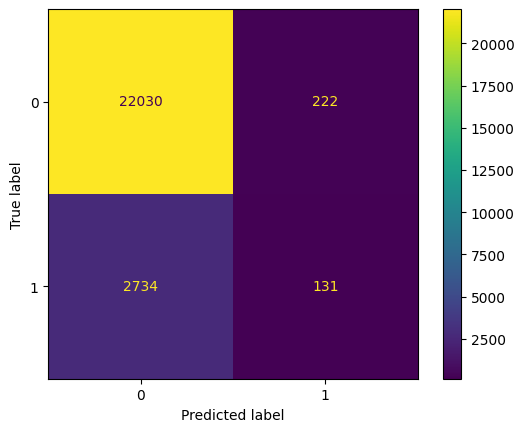

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     22252
           1       0.37      0.05      0.08      2865

    accuracy                           0.88     25117
   macro avg       0.63      0.52      0.51     25117
weighted avg       0.83      0.88      0.84     25117

F1 retrasos decision tree  0.081
-----Database oversampled-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


Decision Tree: 
Resultado en test :


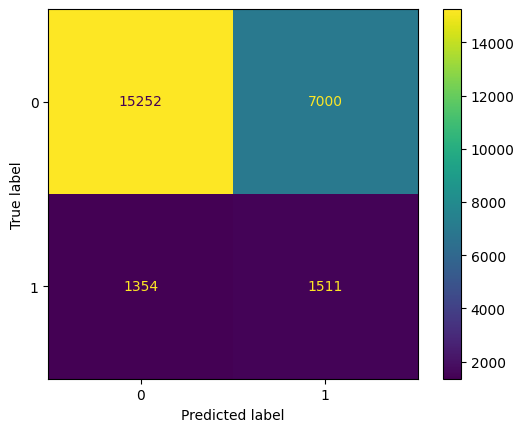

              precision    recall  f1-score   support

           0       0.92      0.69      0.79     22252
           1       0.18      0.53      0.27      2865

    accuracy                           0.67     25117
   macro avg       0.55      0.61      0.53     25117
weighted avg       0.83      0.67      0.73     25117

F1 retrasos decision tree  0.266
-----Database Smote-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


Decision Tree: 
Resultado en test :


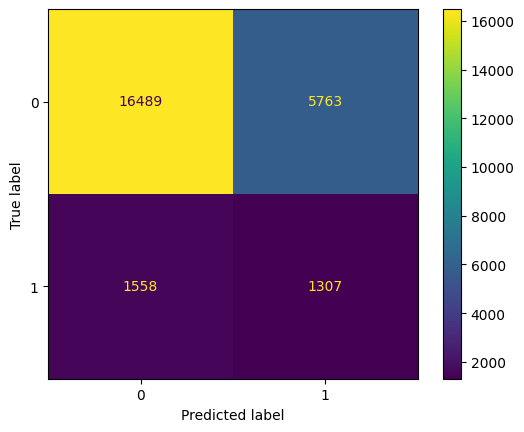

              precision    recall  f1-score   support

           0       0.91      0.74      0.82     22252
           1       0.18      0.46      0.26      2865

    accuracy                           0.71     25117
   macro avg       0.55      0.60      0.54     25117
weighted avg       0.83      0.71      0.76     25117

F1 retrasos decision tree  0.263
-----Database Smote2-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


Decision Tree: 
Resultado en test :


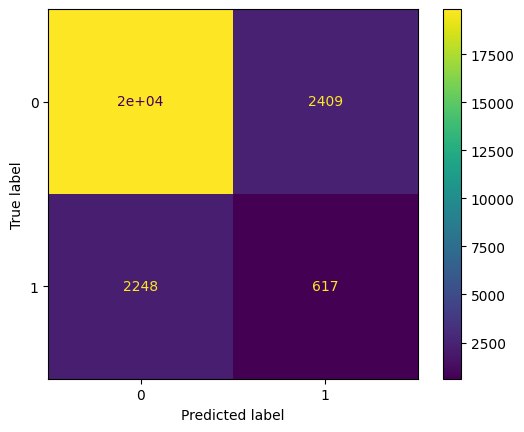

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     22252
           1       0.20      0.22      0.21      2865

    accuracy                           0.81     25117
   macro avg       0.55      0.55      0.55     25117
weighted avg       0.82      0.81      0.82     25117

F1 retrasos decision tree  0.209
----------Aplicando modelo de random forest----------
-----Database original-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


Random forest: 
Resultado en test :


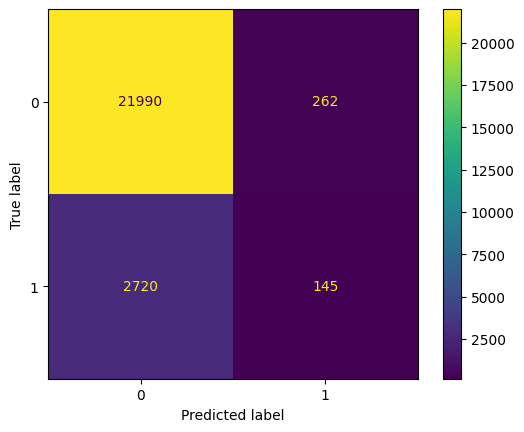

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     22252
           1       0.36      0.05      0.09      2865

    accuracy                           0.88     25117
   macro avg       0.62      0.52      0.51     25117
weighted avg       0.83      0.88      0.84     25117

F1 retrasos random forest  0.089
-----Database oversampled-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


Random forest: 
Resultado en test :


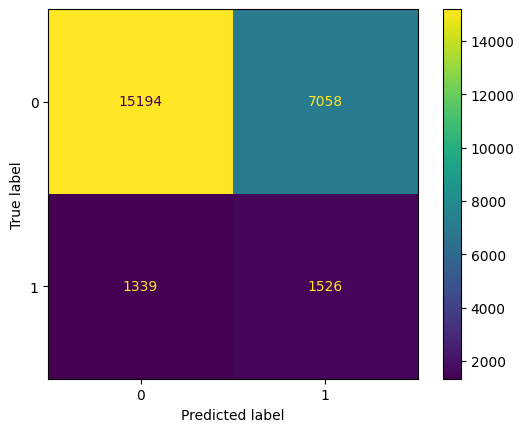

              precision    recall  f1-score   support

           0       0.92      0.68      0.78     22252
           1       0.18      0.53      0.27      2865

    accuracy                           0.67     25117
   macro avg       0.55      0.61      0.53     25117
weighted avg       0.83      0.67      0.72     25117

F1 retrasos random forest  0.267
-----Database Smote-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


Random forest: 
Resultado en test :


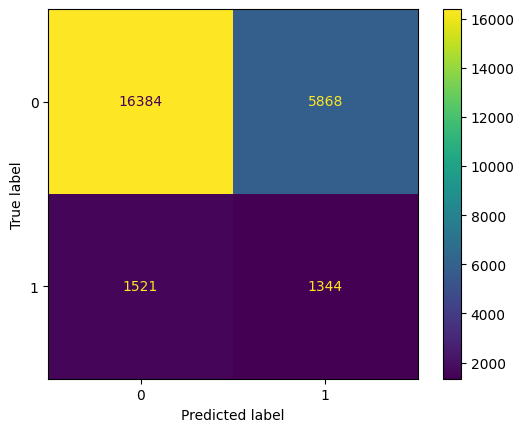

              precision    recall  f1-score   support

           0       0.92      0.74      0.82     22252
           1       0.19      0.47      0.27      2865

    accuracy                           0.71     25117
   macro avg       0.55      0.60      0.54     25117
weighted avg       0.83      0.71      0.75     25117

F1 retrasos random forest  0.267
-----Database Smote2-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


Random forest: 
Resultado en test :


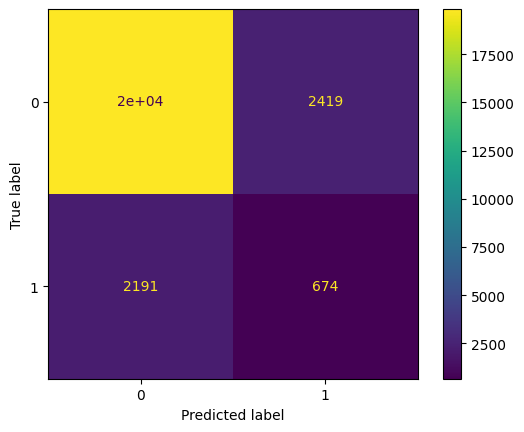

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     22252
           1       0.22      0.24      0.23      2865

    accuracy                           0.82     25117
   macro avg       0.56      0.56      0.56     25117
weighted avg       0.82      0.82      0.82     25117

F1 retrasos random forest  0.226
----------Aplicando modelo de XG Boost---------
-----Database original-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


XG BOOST: 
Resultado en test :


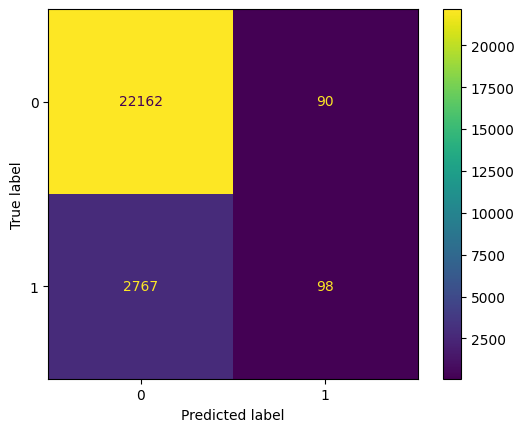

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     22252
           1       0.52      0.03      0.06      2865

    accuracy                           0.89     25117
   macro avg       0.71      0.52      0.50     25117
weighted avg       0.85      0.89      0.84     25117

F1 retrasos XG BOOST  0.064
-----Database oversampled-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


XG BOOST: 
Resultado en test :


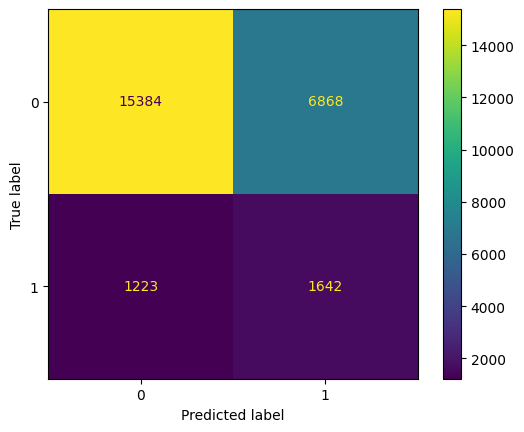

              precision    recall  f1-score   support

           0       0.93      0.69      0.79     22252
           1       0.19      0.57      0.29      2865

    accuracy                           0.68     25117
   macro avg       0.56      0.63      0.54     25117
weighted avg       0.84      0.68      0.73     25117

F1 retrasos XG BOOST  0.289
-----Database Smote-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


XG BOOST: 
Resultado en test :


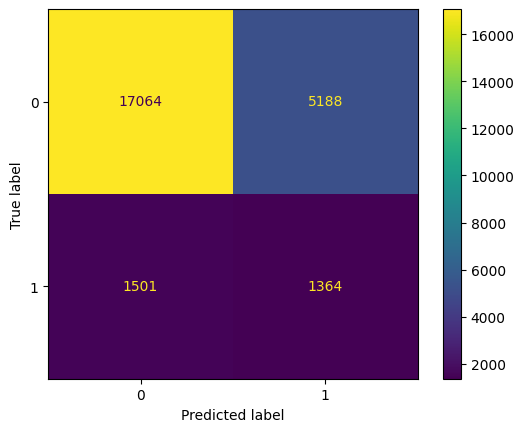

              precision    recall  f1-score   support

           0       0.92      0.77      0.84     22252
           1       0.21      0.48      0.29      2865

    accuracy                           0.73     25117
   macro avg       0.56      0.62      0.56     25117
weighted avg       0.84      0.73      0.77     25117

F1 retrasos XG BOOST  0.29
-----Database Smote2-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


XG BOOST: 
Resultado en test :


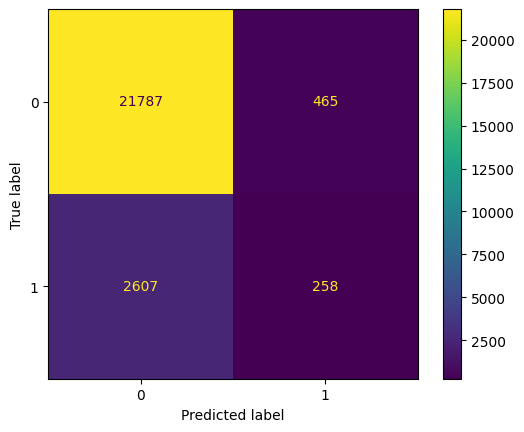

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     22252
           1       0.36      0.09      0.14      2865

    accuracy                           0.88     25117
   macro avg       0.62      0.53      0.54     25117
weighted avg       0.83      0.88      0.84     25117

F1 retrasos XG BOOST  0.144


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


In [ ]:
apply_tree_rf_xgb(X_train, X_test, y_train, y_test,X_train_res, y_train_res,X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2)

In [ ]:
df_metricas

,base_binaria,top_variables,type_encoding,sacar_pas_0,sacar_buenos_aires,minutos_retraso,balanceo,modelo,f1_score_retrasos,recal_retrasos,precision_retrasos,total_accuracy
0,True,True,target,False,False,15,Sin balanceo,Regresión logística,0.041,0.021,0.550,0.886
1,True,True,target,False,False,15,Sin balanceo,SGD,0.000,0.000,0.000,0.886
2,True,True,target,False,False,15,Oversampling,Regresión logística,0.283,0.528,0.193,0.694
3,True,True,target,False,False,15,Oversampling,SGD,0.279,0.389,0.218,0.771
4,True,True,target,False,False,15,Smote,Regresión logística,0.282,0.532,0.192,0.691
5,True,True,target,False,False,15,Smote,SGD,0.279,0.389,0.218,0.771
6,True,True,target,False,False,15,Smote2,Regresión logística,0.220,0.170,0.311,0.862
7,True,True,target,False,False,15,Smote2,SGD,0.154,0.097,0.384,0.879
8,True,True,target,False,False,15,Sin balanceo,Decision Tree,0.081,0.046,0.371,0.882
9,True,True,target,False,False,15,Oversampling,Decision Tree,0.266,0.527,0.178,0.667


Por ahora vemos en la df_metricas que el mejor modelo ha sido XG Boost y regresión logística, para el oversampling y el Smote (v1 de Smote). A continuación eliminamos la df_metricas y aplicamos nuevamente pero para varios parámetros iniciales. Por otro lado, vemos que para las técnicas Sin Balanceo y Smote2 los resultados son siempre peores, por lo cual para ahorrar tiempo vamos a omitir esas dos pruebas a partir de ahora y dejamos solo Smote y Oversampling:

In [ ]:
from IPython.display import display
def aplicar_preproc_y_modelos(base_binaria,top_variables,type_encoding,sacar_pas_0,sacar_buenos_aires,minutos_retraso,test_size):

  df = pd.read_csv("https://raw.githubusercontent.com/Fran-Brogiolo/DataScienceDiploma/master/Mentor%C3%ADa%20Big%20Data%20Bang/df_final_sin_encoding_TP2.csv", parse_dates=['Horario_Prog_Arribo'])
  df = preprocessing(df,base_binaria,top_variables,type_encoding,sacar_pas_0,sacar_buenos_aires,minutos_retraso)
  display(df.info())


  X, y = separar_x_y(df)
  X_train, X_test, y_train, y_test = train_test_normal(X, y, test_size)
  #Oversampling
  print("Oversampling")
  X_train_res, y_train_res = train_test_oversampling(X_train, y_train)
  #Smote
  print("Smote")
  X_train_Smote, y_train_Smote = train_test_over_SMOTE(X_train, y_train)
  #Smote 2
  #print("Smote 2")
  #X_train_Smote2, y_train_Smote2 = train_test_over_SMOTE_2(X_train, y_train)


  apply_tree_rf_xgb(X_train, X_test, y_train, y_test,X_train_res, y_train_res,
                    X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2,apply_all=False)
  apply_regresionlog_y_SGD(X_train, X_test, y_train, y_test,X_train_res, y_train_res,
                           X_train_Smote, y_train_Smote,X_train_Smote2, y_train_Smote2,apply_all=False)

Primero vemos cuanto tarda correr todo una sola vez:

In [ ]:
base_binaria_list = [False]
top_variables_list = [False]
type_encoding_list = ["label"] #Possible values are "one-hot", "target" or "label"
sacar_pas_0_list = [False] #false es para que NO estén los vuelos con 0 pasajeros
sacar_buenos_aires_list = [False]
minutos_retraso_list = [15]
test_size_list = [0.2]

Consideramos  15 minutos como retraso.
Distribución de retrasos/adelantos
 0    75518
-1    35741
 1    14324
Name: Retraso, dtype: int64
Usamos todas las  14  features originales
Elegimos resolver un problema de multiclase, incluyendo adelantos.
Df sin encoding: 


,Riesgo_Vuelos_Ult_8_hs,Cant_Pasajeros,Hora_Vuelo,Cinta_Equipajes,Distancia_km,Cabecera_Arribo,Mes_Vuelo,Pais_Aeropuerto,Ciudad_Aeropuerto,Nombre_Aerolinea,Sector,Dia_Semana,Uso_Aeronave,Terminal_Arribo,Retraso
0,0,100,1,8,1048,31,1,Argentina,Puerto Iguazú,DN,2,Tuesday,Transporte de pasajeros,A,-1
1,0,44,8,9,650,13,1,Argentina,Córdoba,DN,2,Tuesday,Transporte de pasajeros,A,-1
2,0,81,9,7,650,13,1,Argentina,Córdoba,4M,2,Tuesday,Transporte de pasajeros,A,-1
3,0,105,9,1,1692,13,1,Brasil,São Paulo,4M,I,Tuesday,Transporte de pasajeros,A,-1
4,0,114,8,5,980,13,1,Argentina,Mendoza,AR,2,Tuesday,Transporte de pasajeros,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125578,0,2,19,0,996,13,7,Argentina,Neuquén,PRV,N,Thursday,Privado,A,0
125579,0,0,6,0,980,13,7,Argentina,Mendoza,PRV,2,Friday,Privado,A,0
125580,0,2,7,0,980,13,7,Argentina,Mendoza,PRV,N,Friday,Privado,A,0
125581,0,0,8,0,990,13,7,Argentina,San Juan,PRV,2,Friday,Militar,A,0


<ipython-input-96-f0c4ceddeca2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columna] = df[columna].astype('category')
<ipython-input-96-f0c4ceddeca2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columna] = df[columna].astype('category')
<ipython-input-96-f0c4ceddeca2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

Realizamos  label encoding para columnas con más de 5 categorías. Para menos de 5 mantenemos one-hot
Df after encoding: 


,Riesgo_Vuelos_Ult_8_hs,Cant_Pasajeros,Hora_Vuelo,Cinta_Equipajes,Distancia_km,Mes_Vuelo,Pais_Aeropuerto,Ciudad_Aeropuerto,Nombre_Aerolinea,Sector,Dia_Semana,Retraso,Cabecera_Arribo_13,Cabecera_Arribo_31,Uso_Aeronave_Militar,Uso_Aeronave_Privado,Uso_Aeronave_Transporte de pasajeros,Terminal_Arribo_A,Terminal_Arribo_B
0,0,100,15.0,9.0,1048,0.0,0,0,0,0,0.0,-1,0,1,0,0,1,1,0
1,0,44,1.0,5.0,650,0.0,0,1,0,0,0.0,-1,1,0,0,0,1,1,0
2,0,81,23.0,8.0,650,0.0,0,1,1,0,0.0,-1,1,0,0,0,1,1,0
3,0,105,23.0,5.0,1692,0.0,1,2,1,1,0.0,-1,1,0,0,0,1,1,0
4,0,114,1.0,7.0,980,0.0,0,3,2,0,0.0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125578,0,2,8.0,9.0,996,6.0,0,9,7,2,2.0,0,1,0,0,1,0,1,0
125579,0,0,16.0,9.0,980,6.0,0,3,7,0,3.0,0,1,0,0,1,0,1,0
125580,0,2,14.0,9.0,980,6.0,0,3,7,2,3.0,0,1,0,0,1,0,1,0
125581,0,0,1.0,9.0,990,6.0,0,38,7,0,3.0,0,1,0,1,0,0,1,0


Df normalizada: 


,Riesgo_Vuelos_Ult_8_hs,Cant_Pasajeros,Hora_Vuelo,Cinta_Equipajes,Distancia_km,Mes_Vuelo,Pais_Aeropuerto,Ciudad_Aeropuerto,Nombre_Aerolinea,Sector,Dia_Semana,Retraso,Cabecera_Arribo_13,Cabecera_Arribo_31,Uso_Aeronave_Militar,Uso_Aeronave_Privado,Uso_Aeronave_Transporte de pasajeros,Terminal_Arribo_A,Terminal_Arribo_B
0,0,0.444444,0.636364,1.00,0.068929,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,-1,0,1,0,0,1,1,0
1,0,0.195556,0.000000,0.00,0.042752,0.000000,0.000000,0.005236,0.000000,0.00,0.000000,-1,1,0,0,0,1,1,0
2,0,0.360000,1.000000,0.75,0.042752,0.000000,0.000000,0.005236,0.045455,0.00,0.000000,-1,1,0,0,0,1,1,0
3,0,0.466667,1.000000,0.00,0.111287,0.000000,0.022727,0.010471,0.045455,0.25,0.000000,-1,1,0,0,0,1,1,0
4,0,0.506667,0.000000,0.50,0.064457,0.000000,0.000000,0.015707,0.090909,0.00,0.000000,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125578,0,0.008889,0.318182,1.00,0.065509,0.545455,0.000000,0.047120,0.318182,0.50,0.333333,0,1,0,0,1,0,1,0
125579,0,0.000000,0.681818,1.00,0.064457,0.545455,0.000000,0.015707,0.318182,0.00,0.500000,0,1,0,0,1,0,1,0
125580,0,0.008889,0.590909,1.00,0.064457,0.545455,0.000000,0.015707,0.318182,0.50,0.500000,0,1,0,0,1,0,1,0
125581,0,0.000000,0.000000,1.00,0.065114,0.545455,0.000000,0.198953,0.318182,0.00,0.500000,0,1,0,1,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125583 entries, 0 to 125582
Data columns (total 19 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Riesgo_Vuelos_Ult_8_hs                125583 non-null  int64  
 1   Cant_Pasajeros                        125583 non-null  float64
 2   Hora_Vuelo                            125583 non-null  float64
 3   Cinta_Equipajes                       125583 non-null  float64
 4   Distancia_km                          125583 non-null  float64
 5   Mes_Vuelo                             125583 non-null  float64
 6   Pais_Aeropuerto                       125583 non-null  float64
 7   Ciudad_Aeropuerto                     125583 non-null  float64
 8   Nombre_Aerolinea                      125583 non-null  float64
 9   Sector                                125583 non-null  float64
 10  Dia_Semana                            125583 non-null  float64
 11  

None

Proporción de clases antes de la separación:
 0    0.601339
-1    0.284601
 1    0.114060
Name: Retraso, dtype: float64

Proporción de clases en el conjunto de entrenamiento:
 0    0.601338
-1    0.284604
 1    0.114058
Name: Retraso, dtype: float64

Proporción de clases en el conjunto de prueba:
 0    0.601346
-1    0.284588
 1    0.114066
Name: Retraso, dtype: float64
Tenemos 100466 entradas de entrenamiento
Tenemos 25117 entradas de test
Oversampling
Distribucion antes del resampling Counter({0: 60414, -1: 28593, 1: 11459})
Distribucion despues del resampling Counter({0: 60414, 1: 60414, -1: 60414})
Smote
Distribucion antes del resampling Counter({0: 60414, -1: 28593, 1: 11459})
Distribucion despues del resampling Counter({0: 60414, 1: 60414, -1: 60414})
----------Aplicando modelo de Decision Tree----------
-----Database oversampled-----
Decision Tree: 
Resultado en test :


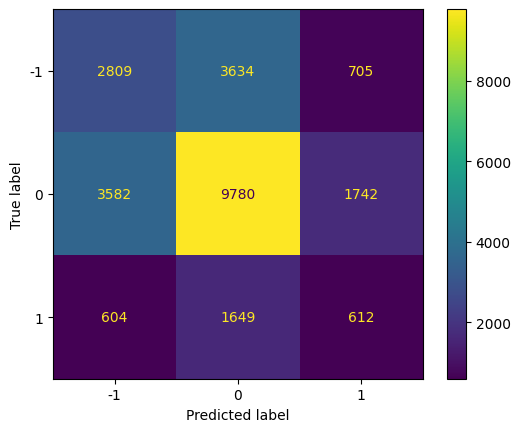

              precision    recall  f1-score   support

          -1       0.40      0.39      0.40      7148
           0       0.65      0.65      0.65     15104
           1       0.20      0.21      0.21      2865

    accuracy                           0.53     25117
   macro avg       0.42      0.42      0.42     25117
weighted avg       0.53      0.53      0.53     25117

F1 retrasos decision tree  0.207
-----Database Smote-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


Decision Tree: 
Resultado en test :


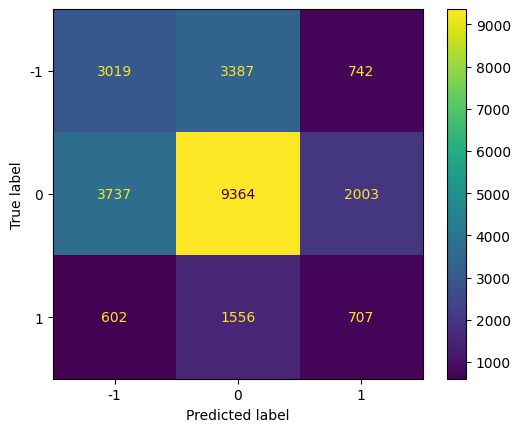

              precision    recall  f1-score   support

          -1       0.41      0.42      0.42      7148
           0       0.65      0.62      0.64     15104
           1       0.20      0.25      0.22      2865

    accuracy                           0.52     25117
   macro avg       0.42      0.43      0.43     25117
weighted avg       0.53      0.52      0.53     25117

F1 retrasos decision tree  0.224
----------Aplicando modelo de random forest----------
-----Database oversampled-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


Random forest: 
Resultado en test :


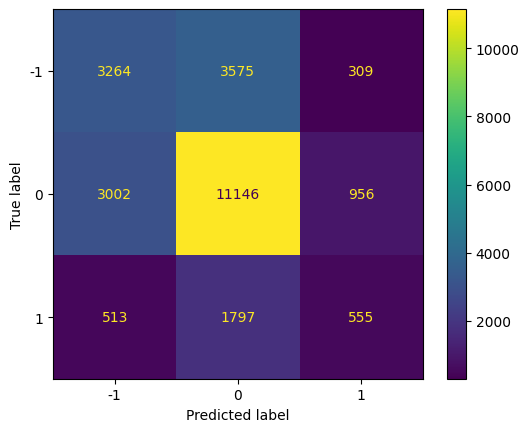

              precision    recall  f1-score   support

          -1       0.48      0.46      0.47      7148
           0       0.67      0.74      0.70     15104
           1       0.30      0.19      0.24      2865

    accuracy                           0.60     25117
   macro avg       0.49      0.46      0.47     25117
weighted avg       0.58      0.60      0.58     25117

F1 retrasos random forest  0.237
-----Database Smote-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


Random forest: 
Resultado en test :


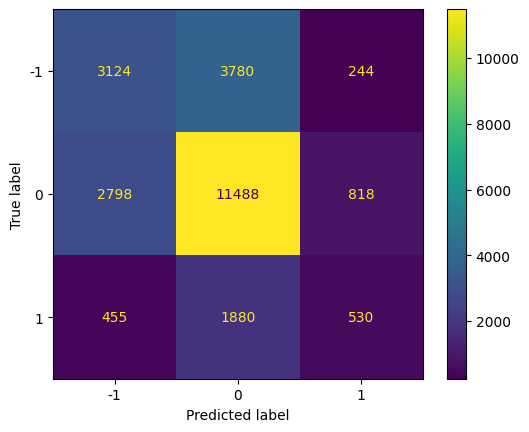

              precision    recall  f1-score   support

          -1       0.49      0.44      0.46      7148
           0       0.67      0.76      0.71     15104
           1       0.33      0.18      0.24      2865

    accuracy                           0.60     25117
   macro avg       0.50      0.46      0.47     25117
weighted avg       0.58      0.60      0.59     25117

F1 retrasos random forest  0.238
----------Aplicando modelo de XG Boost---------
-----Database oversampled-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


XG BOOST: 
Resultado en test :


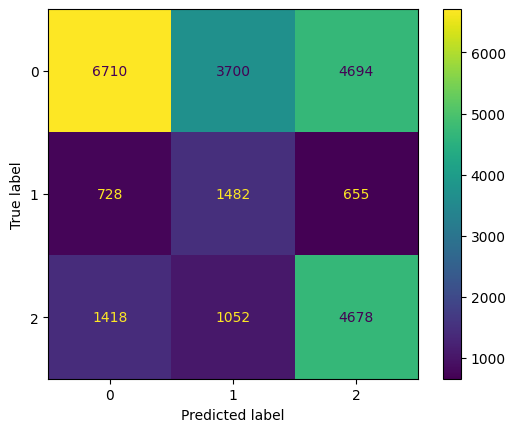

              precision    recall  f1-score   support

           0       0.76      0.44      0.56     15104
           1       0.24      0.52      0.33      2865
           2       0.47      0.65      0.54      7148

    accuracy                           0.51     25117
   macro avg       0.49      0.54      0.48     25117
weighted avg       0.62      0.51      0.53     25117

F1 retrasos XG BOOST  0.326
-----Database Smote-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)


XG BOOST: 
Resultado en test :


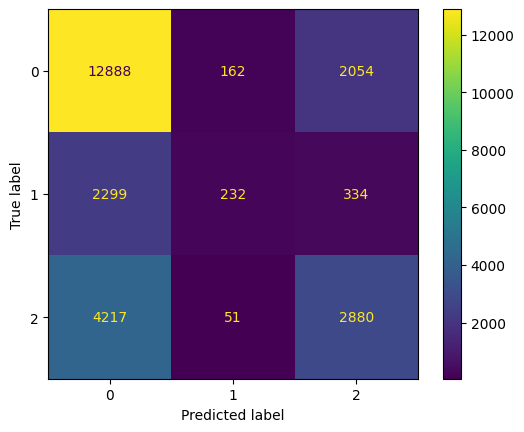

              precision    recall  f1-score   support

           0       0.66      0.85      0.75     15104
           1       0.52      0.08      0.14      2865
           2       0.55      0.40      0.46      7148

    accuracy                           0.64     25117
   macro avg       0.58      0.45      0.45     25117
weighted avg       0.61      0.64      0.60     25117

F1 retrasos XG BOOST  0.14
----------Aplicando modelo de regresión logística y SGD classifier----------
-----Database oversampled-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter

Regresion logistica: 
Resultado en test :


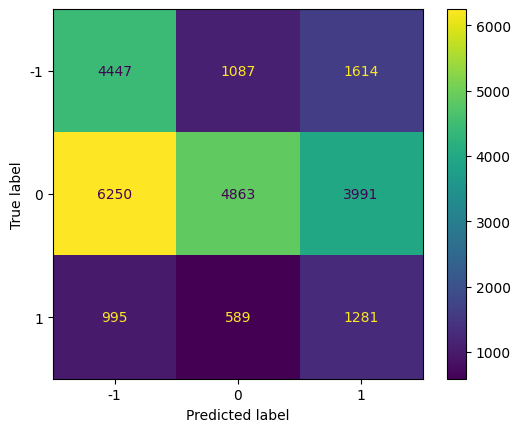

              precision    recall  f1-score   support

          -1       0.38      0.62      0.47      7148
           0       0.74      0.32      0.45     15104
           1       0.19      0.45      0.26      2865

    accuracy                           0.42     25117
   macro avg       0.44      0.46      0.39     25117
weighted avg       0.58      0.42      0.43     25117

F1 retrasos regr. logística  0.263
SGD Classifier: 
Resultado en test :


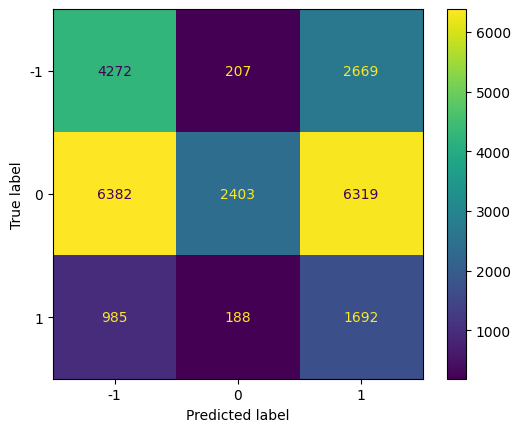

              precision    recall  f1-score   support

          -1       0.37      0.60      0.45      7148
           0       0.86      0.16      0.27     15104
           1       0.16      0.59      0.25      2865

    accuracy                           0.33     25117
   macro avg       0.46      0.45      0.32     25117
weighted avg       0.64      0.33      0.32     25117

F1 retrasos SGD  0.25
-----Database Smote-----


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.appen

Regresion logistica: 
Resultado en test :


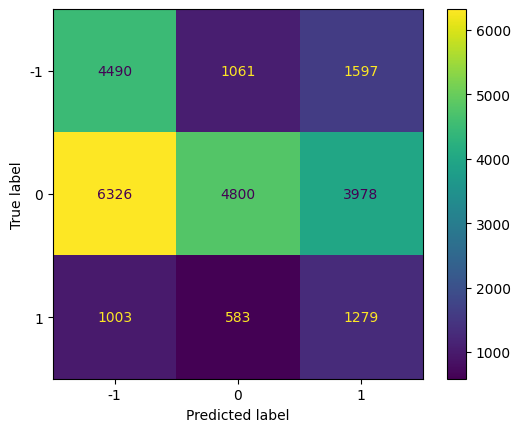

              precision    recall  f1-score   support

          -1       0.38      0.63      0.47      7148
           0       0.74      0.32      0.45     15104
           1       0.19      0.45      0.26      2865

    accuracy                           0.42     25117
   macro avg       0.44      0.46      0.39     25117
weighted avg       0.58      0.42      0.43     25117

F1 retrasos regr. logística  0.263
SGD Classifier: 
Resultado en test :


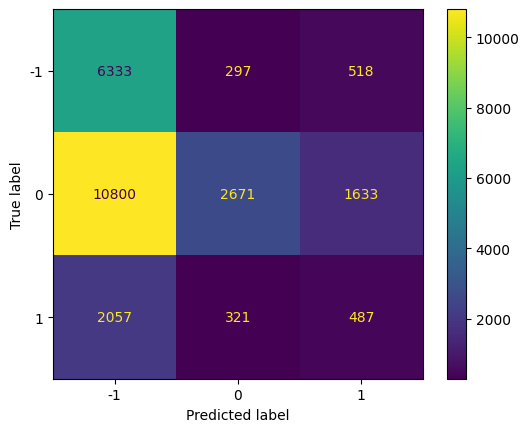

              precision    recall  f1-score   support

          -1       0.33      0.89      0.48      7148
           0       0.81      0.18      0.29     15104
           1       0.18      0.17      0.18      2865

    accuracy                           0.38     25117
   macro avg       0.44      0.41      0.32     25117
weighted avg       0.60      0.38      0.33     25117

F1 retrasos SGD  0.177


<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metricas = df_metricas.append(configuracion, ignore_index=True)
<ipython-input-105-2a7d2096c1fb>:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_metricas = df_metricas.appen

,base_binaria,top_variables,type_encoding,sacar_pas_0,sacar_buenos_aires,minutos_retraso,balanceo,modelo,f1_score_retrasos,recal_retrasos,precision_retrasos,total_accuracy
0,False,False,label,False,False,15,Oversampling,Decision Tree,0.207,0.214,0.200,0.526
1,False,False,label,False,False,15,Smote,Decision Tree,0.224,0.247,0.205,0.521
2,False,False,label,False,False,15,Oversampling,Random forest,0.237,0.194,0.305,0.596
3,False,False,label,False,False,15,Smote,Random forest,0.238,0.185,0.333,0.603
4,False,False,label,False,False,15,Oversampling,XG Boost,0.326,0.517,0.238,0.512
5,False,False,label,False,False,15,Smote,XG Boost,0.140,0.081,0.521,0.637
6,False,False,label,False,False,15,Oversampling,Regresión logística,0.263,0.447,0.186,0.422
7,False,False,label,False,False,15,Oversampling,SGD,0.250,0.591,0.158,0.333
8,False,False,label,False,False,15,Smote,Regresión logística,0.263,0.446,0.187,0.421
9,False,False,label,False,False,15,Smote,SGD,0.177,0.170,0.185,0.378


In [ ]:
#creamos de nuevo la df_metricas para que esté vacía
df_metricas = create_df_metricas()
import time

# Registra el tiempo de inicio
inicio = time.time()

for base_binaria in base_binaria_list:
  for top_variables in top_variables_list:
    for type_encoding in type_encoding_list:
      for sacar_pas_0 in sacar_pas_0_list:
        for sacar_buenos_aires in sacar_buenos_aires_list:
          for minutos_retraso in minutos_retraso_list:
            for test_size in test_size_list:
              aplicar_preproc_y_modelos(base_binaria,top_variables,type_encoding,sacar_pas_0,sacar_buenos_aires,minutos_retraso,test_size)

# Registra el tiempo de finalización
fin = time.time()

# Calcula la diferencia de tiempo
tiempo_transcurrido = fin - inicio


df_metricas

In [ ]:
print(f"Tiempo transcurrido: {round(tiempo_transcurrido,2)} segundos")

Tiempo transcurrido: 266.92 segundos


Se probaron todas estas configuraciones, y obtuvimos el df_metricas_completo que leemos en la siguiente celda. No se corre aquí porque demora varias horas en correr, los resultados se subieron a github para poder leerlos directamente:

In [ ]:
base_binaria_list = [True,False]
top_variables_list = [True,False]
type_encoding_list = ["target","label"] #Possible values are "one-hot", "target" or "label"
sacar_pas_0_list = [True,False] #false es para que NO estén los vuelos con 0 pasajeros
sacar_buenos_aires_list = [True,False]
minutos_retraso_list = [15,30,60]
test_size_list = [0.2]

In [ ]:
df_metricas_completo = pd.read_csv("https://raw.githubusercontent.com/Fran-Brogiolo/DataScienceDiploma/master/Mentor%C3%ADa%20Big%20Data%20Bang/metricas_completo.txt")
df_metricas_completo

,base_binaria,top_variables,type_encoding,sacar_pas_0,sacar_buenos_aires,minutos_retraso,balanceo,modelo,f1_score_retrasos,recal_retrasos,precision_retrasos,total_accuracy
0,True,True,target,True,True,15,Oversampling,Decision Tree,0.251,0.536,0.164,0.646
1,True,True,target,True,True,15,Smote,Decision Tree,0.243,0.436,0.169,0.700
2,True,True,target,True,True,15,Oversampling,Random forest,0.251,0.538,0.163,0.644
3,True,True,target,True,True,15,Smote,Random forest,0.245,0.446,0.169,0.695
4,True,True,target,True,True,15,Oversampling,XG Boost,0.265,0.566,0.173,0.652
...,...,...,...,...,...,...,...,...,...,...,...,...
955,False,False,label,False,False,60,Smote,XG Boost,0.075,0.041,0.520,0.959
956,False,False,label,False,False,60,Oversampling,RegresiÃ³n logÃ­stica,0.115,0.436,0.066,0.620
957,False,False,label,False,False,60,Oversampling,SGD,0.131,0.373,0.080,0.642
958,False,False,label,False,False,60,Smote,RegresiÃ³n logÃ­stica,0.114,0.455,0.065,0.617


In [ ]:
df_metricas_completo.describe()

,minutos_retraso,f1_score_retrasos,recal_retrasos,precision_retrasos,total_accuracy
count,960.000000,960.000000,960.000000,960.000000,960.000000
mean,35.000000,0.173553,0.370164,0.158237,0.674543
std,18.718038,0.067666,0.185226,0.098975,0.196476
min,15.000000,0.000000,0.000000,0.000000,0.039000
25%,15.000000,0.122750,0.231750,0.085000,0.563750
50%,30.000000,0.178000,0.423000,0.133000,0.707000
75%,60.000000,0.227000,0.496250,0.193000,0.807000
max,60.000000,0.326000,0.984000,0.694000,0.964000


In [ ]:
# Ordena el DataFrame en función de la columna 'f1_score_retrasos' en orden descendente y toma las primeras 10 filas
top_10_df = df_metricas_completo.sort_values(by='f1_score_retrasos', ascending=False).head(10)

# Ahora puedes imprimir el DataFrame top_10_df
top_10_df

,base_binaria,top_variables,type_encoding,sacar_pas_0,sacar_buenos_aires,minutos_retraso,balanceo,modelo,f1_score_retrasos,recal_retrasos,precision_retrasos,total_accuracy
934,False,False,label,False,False,15,Oversampling,XG Boost,0.326,0.520,0.241,0.514
814,False,False,target,False,False,15,Oversampling,XG Boost,0.321,0.497,0.237,0.512
334,True,False,target,False,False,15,Oversampling,XG Boost,0.315,0.578,0.217,0.714
454,True,False,label,False,False,15,Oversampling,XG Boost,0.315,0.581,0.216,0.712
784,False,False,target,False,True,15,Oversampling,XG Boost,0.314,0.497,0.230,0.514
874,False,False,label,True,False,15,Oversampling,XG Boost,0.311,0.495,0.227,0.512
904,False,False,label,False,True,15,Oversampling,XG Boost,0.306,0.491,0.222,0.511
724,False,False,target,True,True,15,Oversampling,XG Boost,0.306,0.482,0.224,0.505
844,False,False,label,True,True,15,Oversampling,XG Boost,0.303,0.487,0.220,0.502
754,False,False,target,True,False,15,Oversampling,XG Boost,0.302,0.478,0.220,0.507


Vemos que el modelo XG Boost con el metodo Oversampling es que mejor performa.

In [ ]:
indice_max_f1_score = df_metricas_completo['f1_score_retrasos'].idxmax()

# Obtiene la fila completa correspondiente al índice máximo
fila_max_f1_score = df_metricas_completo.loc[indice_max_f1_score]
fila_max_f1_score

base_binaria                 False
top_variables                False
type_encoding                label
sacar_pas_0                  False
sacar_buenos_aires           False
minutos_retraso                 15
balanceo              Oversampling
modelo                    XG Boost
f1_score_retrasos            0.326
recal_retrasos                0.52
precision_retrasos           0.241
total_accuracy               0.514
Name: 934, dtype: object

Por lo cual dejaremos esta configuración para posteriormente optimizar hiperparámetros.

### b)  Evaluar sobre el conjunto de entrenamiento, validación y test reportando: i. Accuracy ii. Precision iii. Recall iv. F1 v. Matriz de confusión


### c) Elaborar conclusiones en base a la métrica a optimizar y comparar con el modelo baseline.

## 5)  Ajuste por hiperparámetros:


### a)  Para los dos “mejores modelos” obtenidos en los puntos anteriores, seleccionar valores para los hiperparámetros principales de dichos modelos (ajustar con por lo menos 3 parámetros). Utilizar grid-search y k-fold cross-validation

Tomamos solo para el mejor modelo:

In [ ]:
base_binaria = False
top_variables = False
type_encoding = "label" #Possible values are "one-hot", "target" or "label"
sacar_pas_0 = False #false es para que NO estén los vuelos con 0 pasajeros
sacar_buenos_aires = False
minutos_retraso = 15

test_size = 0.2

df = pd.read_csv("https://raw.githubusercontent.com/Fran-Brogiolo/DataScienceDiploma/master/Mentor%C3%ADa%20Big%20Data%20Bang/df_final_sin_encoding_TP2.csv", parse_dates=['Horario_Prog_Arribo'])
df = preprocessing(df,base_binaria,top_variables,type_encoding,sacar_pas_0,sacar_buenos_aires,minutos_retraso)

X, y = separar_x_y(df)
X_train, X_test, y_train, y_test = train_test_normal(X, y, test_size)
#Oversampling
print("Oversampling")
X_train_res, y_train_res = train_test_oversampling(X_train, y_train)

Consideramos  15 minutos como retraso.
Distribución de retrasos/adelantos
 0    75518
-1    35741
 1    14324
Name: Retraso, dtype: int64
Usamos todas las  14  features originales
Elegimos resolver un problema de multiclase, incluyendo adelantos.
Df sin encoding: 


,Riesgo_Vuelos_Ult_8_hs,Cant_Pasajeros,Hora_Vuelo,Cinta_Equipajes,Distancia_km,Cabecera_Arribo,Mes_Vuelo,Pais_Aeropuerto,Ciudad_Aeropuerto,Nombre_Aerolinea,Sector,Dia_Semana,Uso_Aeronave,Terminal_Arribo,Retraso
0,0,100,1,8,1048,31,1,Argentina,Puerto Iguazú,DN,2,Tuesday,Transporte de pasajeros,A,-1
1,0,44,8,9,650,13,1,Argentina,Córdoba,DN,2,Tuesday,Transporte de pasajeros,A,-1
2,0,81,9,7,650,13,1,Argentina,Córdoba,4M,2,Tuesday,Transporte de pasajeros,A,-1
3,0,105,9,1,1692,13,1,Brasil,São Paulo,4M,I,Tuesday,Transporte de pasajeros,A,-1
4,0,114,8,5,980,13,1,Argentina,Mendoza,AR,2,Tuesday,Transporte de pasajeros,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125578,0,2,19,0,996,13,7,Argentina,Neuquén,PRV,N,Thursday,Privado,A,0
125579,0,0,6,0,980,13,7,Argentina,Mendoza,PRV,2,Friday,Privado,A,0
125580,0,2,7,0,980,13,7,Argentina,Mendoza,PRV,N,Friday,Privado,A,0
125581,0,0,8,0,990,13,7,Argentina,San Juan,PRV,2,Friday,Militar,A,0


<ipython-input-96-f0c4ceddeca2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columna] = df[columna].astype('category')
<ipython-input-96-f0c4ceddeca2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columna] = df[columna].astype('category')
<ipython-input-96-f0c4ceddeca2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

Realizamos  label encoding para columnas con más de 5 categorías. Para menos de 5 mantenemos one-hot
Df after encoding: 


,Riesgo_Vuelos_Ult_8_hs,Cant_Pasajeros,Hora_Vuelo,Cinta_Equipajes,Distancia_km,Mes_Vuelo,Pais_Aeropuerto,Ciudad_Aeropuerto,Nombre_Aerolinea,Sector,Dia_Semana,Retraso,Cabecera_Arribo_13,Cabecera_Arribo_31,Uso_Aeronave_Militar,Uso_Aeronave_Privado,Uso_Aeronave_Transporte de pasajeros,Terminal_Arribo_A,Terminal_Arribo_B
0,0,100,15.0,9.0,1048,0.0,0,0,0,0,0.0,-1,0,1,0,0,1,1,0
1,0,44,1.0,5.0,650,0.0,0,1,0,0,0.0,-1,1,0,0,0,1,1,0
2,0,81,23.0,8.0,650,0.0,0,1,1,0,0.0,-1,1,0,0,0,1,1,0
3,0,105,23.0,5.0,1692,0.0,1,2,1,1,0.0,-1,1,0,0,0,1,1,0
4,0,114,1.0,7.0,980,0.0,0,3,2,0,0.0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125578,0,2,8.0,9.0,996,6.0,0,9,7,2,2.0,0,1,0,0,1,0,1,0
125579,0,0,16.0,9.0,980,6.0,0,3,7,0,3.0,0,1,0,0,1,0,1,0
125580,0,2,14.0,9.0,980,6.0,0,3,7,2,3.0,0,1,0,0,1,0,1,0
125581,0,0,1.0,9.0,990,6.0,0,38,7,0,3.0,0,1,0,1,0,0,1,0


Df normalizada: 


,Riesgo_Vuelos_Ult_8_hs,Cant_Pasajeros,Hora_Vuelo,Cinta_Equipajes,Distancia_km,Mes_Vuelo,Pais_Aeropuerto,Ciudad_Aeropuerto,Nombre_Aerolinea,Sector,Dia_Semana,Retraso,Cabecera_Arribo_13,Cabecera_Arribo_31,Uso_Aeronave_Militar,Uso_Aeronave_Privado,Uso_Aeronave_Transporte de pasajeros,Terminal_Arribo_A,Terminal_Arribo_B
0,0,0.444444,0.636364,1.00,0.068929,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,-1,0,1,0,0,1,1,0
1,0,0.195556,0.000000,0.00,0.042752,0.000000,0.000000,0.005236,0.000000,0.00,0.000000,-1,1,0,0,0,1,1,0
2,0,0.360000,1.000000,0.75,0.042752,0.000000,0.000000,0.005236,0.045455,0.00,0.000000,-1,1,0,0,0,1,1,0
3,0,0.466667,1.000000,0.00,0.111287,0.000000,0.022727,0.010471,0.045455,0.25,0.000000,-1,1,0,0,0,1,1,0
4,0,0.506667,0.000000,0.50,0.064457,0.000000,0.000000,0.015707,0.090909,0.00,0.000000,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125578,0,0.008889,0.318182,1.00,0.065509,0.545455,0.000000,0.047120,0.318182,0.50,0.333333,0,1,0,0,1,0,1,0
125579,0,0.000000,0.681818,1.00,0.064457,0.545455,0.000000,0.015707,0.318182,0.00,0.500000,0,1,0,0,1,0,1,0
125580,0,0.008889,0.590909,1.00,0.064457,0.545455,0.000000,0.015707,0.318182,0.50,0.500000,0,1,0,0,1,0,1,0
125581,0,0.000000,0.000000,1.00,0.065114,0.545455,0.000000,0.198953,0.318182,0.00,0.500000,0,1,0,1,0,0,1,0


Proporción de clases antes de la separación:
 0    0.601339
-1    0.284601
 1    0.114060
Name: Retraso, dtype: float64

Proporción de clases en el conjunto de entrenamiento:
 0    0.601338
-1    0.284604
 1    0.114058
Name: Retraso, dtype: float64

Proporción de clases en el conjunto de prueba:
 0    0.601346
-1    0.284588
 1    0.114066
Name: Retraso, dtype: float64
Tenemos 100466 entradas de entrenamiento
Tenemos 25117 entradas de test
Oversampling
Distribucion antes del resampling Counter({0: 60414, -1: 28593, 1: 11459})
Distribucion despues del resampling Counter({0: 60414, 1: 60414, -1: 60414})


XG BOOST: 
Resultado en test :


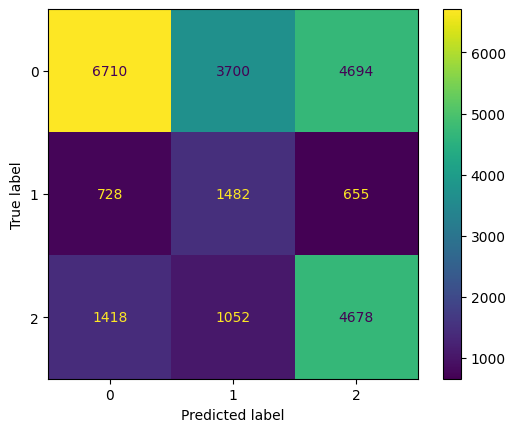

              precision    recall  f1-score   support

           0       0.76      0.44      0.56     15104
           1       0.24      0.52      0.33      2865
           2       0.47      0.65      0.54      7148

    accuracy                           0.51     25117
   macro avg       0.49      0.54      0.48     25117
weighted avg       0.62      0.51      0.53     25117

F1 retrasos XG BOOST  0.326


(0.326, 0.517, 0.238, 0.512)

In [ ]:
xgboost(X_train_res, y_train_res, X_test, y_test)

Partimos de un modelo XGBoost base con un f1 score de 0.326 para la clase a predecir. Para mejorar la performance del modelo, creamos una función para modelar XGboost modificando los hiperparámetros más significativos. Según la página oficial de Amazon, los parámetros más relevantes en el modelo XGBoost son los siguientes: alpha (hiperparámetro regularización), min_child_weight (cantidad mínima de observaciones en cada hoja), subsample (proporción de muestras utilizadas para entrenar cada árbol), eta (tasa de aprendizaje) y num_round (número de iteraciones). Por ello, iremos modificando dichos hiperparámetros, sumado a max_depth (profundidad máxima de cada árbol) para llegar al mejor modelo.

In [ ]:
import xgboost as xgb

def xgboostv2(X_train, y_train, X_test, y_test, params=None):

  # Convertir -1 a 2 en las etiquetas de entrenamiento y prueba
  y_train = np.where(y_train == -1, 2, y_train)
  y_test = np.where(y_test == -1, 2, y_test)


  # Crear un objeto XGBoostClassifier con los parámetros especificados
  if params is None:
    params = {
      'objective': 'multi:softmax',  # Objetivo para clasificación multiclase
      'num_class': 3,               # Número de clases
      'max_depth': 6,               # Profundidad máxima del árbol
      'eta': 0.3,                   # Tasa de aprendizaje (learning rate)
      'alpha': 0,                 # Parámetro alpha (regularización L1)
      'min_child_weight': 1.0,      # Parámetro min_child_weight
      'subsample': 1,             # Parámetro subsample
    }

  model = xgb.XGBClassifier(**params)

  # Entrenar el modelo en los datos de entrenamiento
  model.fit(X_train, y_train)

  # Realizar predicciones en los datos de prueba
  y_pred = model.predict(X_test)

  print("XG BOOST: ")
  matriz_confusion(y_test,y_pred, "test")

  f1= round(f1_score(y_test, y_pred, labels=[1], average='macro'),3)
  print("F1 retrasos XG BOOST ", f1)
  recall = round(recall_score(y_test, y_pred, labels=[1], average='macro'),3)
  precision= round(precision_score(y_test, y_pred, labels=[1], average='macro'),3)
  accuracy= round(accuracy_score(y_test, y_pred),3)


  return f1, recall, precision, accuracy

Luego de probar muchas combinaciones con el parámetro max_depth, la óptima es con max_depth=5, ya que el f1 score aumenta de 0.326 a 0.329

XG BOOST: 
Resultado en test :


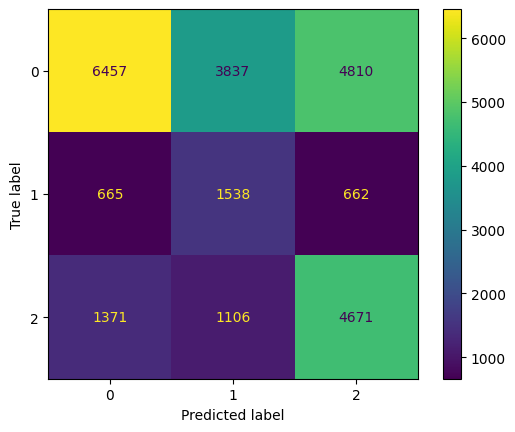

              precision    recall  f1-score   support

           0       0.76      0.43      0.55     15104
           1       0.24      0.54      0.33      2865
           2       0.46      0.65      0.54      7148

    accuracy                           0.50     25117
   macro avg       0.49      0.54      0.47     25117
weighted avg       0.62      0.50      0.52     25117

F1 retrasos XG BOOST  0.329


In [ ]:
f1, recall, precision, accuracy = xgboostv2(X_train_res, y_train_res, X_test, y_test, params={'max_depth': 5})

Al modifcar el hiperparámetro de regularización alpha, el f1 score aumenta a 0,332

XG BOOST: 
Resultado en test :


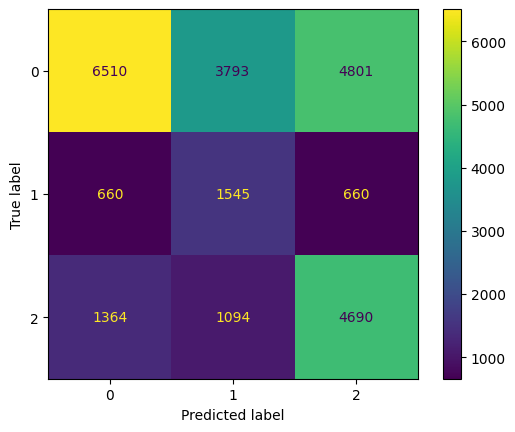

              precision    recall  f1-score   support

           0       0.76      0.43      0.55     15104
           1       0.24      0.54      0.33      2865
           2       0.46      0.66      0.54      7148

    accuracy                           0.51     25117
   macro avg       0.49      0.54      0.48     25117
weighted avg       0.62      0.51      0.52     25117

F1 retrasos XG BOOST  0.332


In [ ]:
f1, recall, precision, accuracy = xgboostv2(X_train_res, y_train_res, X_test, y_test, params={'max_depth': 5, 'alpha': 0.1})

Al modificar el hiperparámetro eta no obtuvimos resultados favorables

Modificamos 'min_child_weight' y concluimos que a mayor 'min_child_weight', menor el f1score de la clase target a optimizar.Por lo tanto, lo dejamos por defecto; min_child_weight = 1.

XG BOOST: 
Resultado en test :


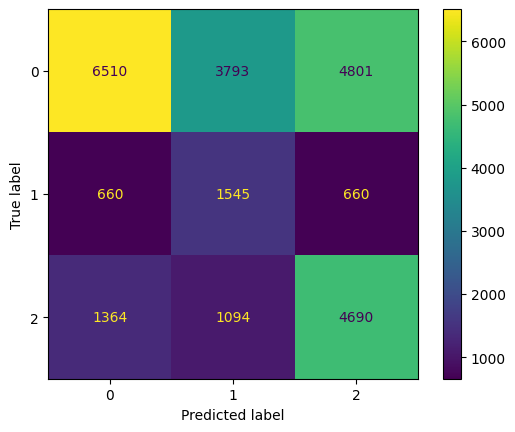

              precision    recall  f1-score   support

           0       0.76      0.43      0.55     15104
           1       0.24      0.54      0.33      2865
           2       0.46      0.66      0.54      7148

    accuracy                           0.51     25117
   macro avg       0.49      0.54      0.48     25117
weighted avg       0.62      0.51      0.52     25117

F1 retrasos XG BOOST  0.332


In [ ]:
f1, recall, precision, accuracy = xgboostv2(X_train_res, y_train_res, X_test, y_test, params={'max_depth': 5, 'alpha': 0.1, 'min_child_weight': 1})

Al modificar el hiperparámetro subsample, tampoco mejora el f1 score

XG BOOST: 
Resultado en test :


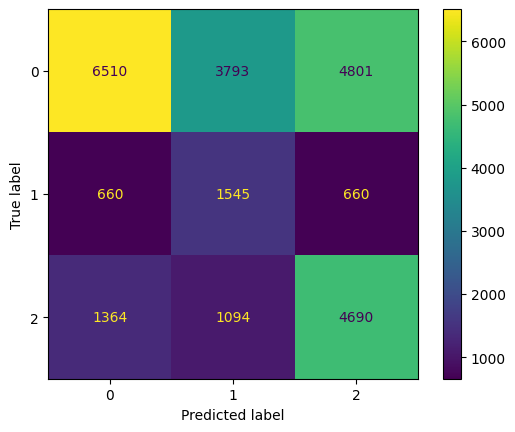

              precision    recall  f1-score   support

           0       0.76      0.43      0.55     15104
           1       0.24      0.54      0.33      2865
           2       0.46      0.66      0.54      7148

    accuracy                           0.51     25117
   macro avg       0.49      0.54      0.48     25117
weighted avg       0.62      0.51      0.52     25117

F1 retrasos XG BOOST  0.332


In [ ]:
f1, recall, precision, accuracy = xgboostv2(X_train_res, y_train_res, X_test, y_test, params={'max_depth': 5, 'alpha': 0.1, 'subsample': 1})

Como conlusion, al modificar los hiperparámetros del modelo XGBoost, el f1 score mejora, pero en una proporción relativamente pequeña.

### b)   Mencionar el mejor modelo obtenido de la Optimización de Hiperparámetros y con cuáles parámetros se obtuvo ese resultado.

El mejor modelo fue el XG Boost con los hiperparámetros y preprocesamiento descriptos anteriormente. Sin embargo, las métricas son muy bajas, no llegando a más del 33% de F1 para la clase de vuelos retrasados.

### c) Con el mejor modelo obtenido realizar las predicciones sobre test y val

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

def xgboostCV(X, y, params=None):
    # Convertir -1 a 2 en las etiquetas
    y = np.where(y == -1, 2, y)

    # Crear un objeto XGBoostClassifier con los parámetros especificados
    if params is None:
        params = {
            'objective': 'multi:softmax',  # Objetivo para clasificación multiclase
            'num_class': 3,               # Número de clases
            'max_depth': 6,               # Profundidad máxima del árbol
            'eta': 0.3,                   # Tasa de aprendizaje (learning rate)
            'alpha': 0,                   # Parámetro alpha (regularización L1)
            'min_child_weight': 1.0,      # Parámetro min_child_weight
            'subsample': 1,               # Parámetro subsample
        }

    model = xgb.XGBClassifier(**params)

    # Realizar validación cruzada
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')  # Cambiar scoring según tu métrica de interés

    # Imprimir resultados de la validación cruzada
    print("F1 macro scores:", scores)


In [ ]:
xgboostCV(X_train_res, y_train_res, params={'max_depth': 5, 'alpha': 0.1, 'subsample': 1})

F1 macro scores: [0.56295263 0.56071735 0.5629421  0.56454035 0.56118782]


No consideramos oportuno realizar la cross validation dado que por un lado, si usamos la base de datos original, sabemos que el resultado es muy malo. Por otro, si usamos la base con oversampling, tenemos muestras repetidas por lo cual es muy probable que haya muestras en el training que se encuentren también en el test, y por ello vemos que se logró un F1 superior a 50% pero ese valor no es real.

### d) Reportar las métricas del mejor modelo, incluyendo las matrices de confusión

Reportadas al final del punto 5.a.

## 6) Comparar el mejor modelo obtenido, con el modelo con parámetros por defecto y con el modelo baseline. Elaborar conclusiones al respecto pensando en la resolución de nuestro problema de clasificación

El modelo obtenido habiendo optimizado los hiperparámetros presenta una mejora poco significativa vs los parámetros por defecto. Al compararlo con el modelo baseline, es mucho mejor ya que el baseline no predecía ni un solo atraso.

Dada las métricas bajas para todas las pruebas realizadas, se concluye que como futuras acciones se debería:

-Verificar la veracidad de los datos con un especialista: el % de vuelos retrasados tomando 15 minutos es solamente 11%, mientras que la media mundial se encuentra alrededor del 20%.

-Conseguir más datos: solamente se cuenta con un año completo de pleno funcionamiento sin pandemia. La pandemia redujo fuertemente el tráfico aéreo y así pudo haber afectado en los retrasos.

-El clima es un factor relevante pero se debe conseguir bases de datos del clima de cada ciudad de origen del vuelo.

-Intentar incorporar datos del tráfico aéreo, estado de las aeronaves (mantenimiento, antiguedad, etc.)

-Como vimos en el TP2 no contamos con variables altamente correlacionadas al retraso, por lo cual el resultado era esperable.

Una vez obtenidas métricas aceptables se podría proceder a aplicar un modelo de regresión para predecir el tiempo de retraso.